In [116]:
#Importando bibliotecas
import os 
import sqlalchemy
from sqlalchemy.sql.elements import Label, collate
import numpy as np
import pandas as pd
from pandas.core.arrays import categorical
from pandas.io.formats.format import TextAdjustment
from pandas.io.pickle import read_pickle
from scipy import sparse
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV
from sweetviz import feature_config
from sklearn.compose import ColumnTransformer
from sklearn import tree, ensemble, svm, neighbors, linear_model, naive_bayes
from sklearn.metrics import roc_curve , classification_report, roc_auc_score
pd.set_option('display.max_columns',100)

## Carregando o Banco de Dados
O Banco de dados deve acessar a tabela **tb_abt_no_sells**

In [117]:
# Carregando os paths do banco de dados
dir_local = os.path.dirname(os.path.abspath('__file__'))
dir_project = os.path.dirname(dir_local)
dir_db = os.path.join(dir_project,'Data/olist.db')
# Efetuando a conexão com o SQLAlchemy e carregando o Dataset
con = sqlalchemy.create_engine('sqlite:///'+ dir_db)
load_abt_churn = "SELECT * from tb_abt_no_sells"
dataset = pd.read_sql(load_abt_churn , con)

## Separando uma parte do dataset para Out of Time (OOT)
Nesse caso serão separadas as **2 últimas safras** para OOT as restantes serão utilizadas para o desenvolvimento

In [118]:
safras = dataset['data_lim_safra'].unique()
safras_oot = safras[-1:]

dataset['flag_venda'] = dataset['flag_venda'].astype(int)
df_oot = dataset[ dataset['data_lim_safra'] >= safras_oot[0]].copy()
df = dataset[ dataset['data_lim_safra'] < safras_oot[0]].copy()

## Separando a variável resposta e dividindo entre treino e teste
Será utilizado 25% dos dados para teste e 75% para treino

In [119]:
# Separando as colunas de features e target e separando os dados entre treino e teste
target = 'flag_venda'
df_columns = df.columns.to_list()
to_remove = ['flag_venda', 'data_lim_safra', 'seller_id']
features = []
for x in df_columns:
    if x not in to_remove:
        features.append(x)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                    stratify= df[target], random_state= 200)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



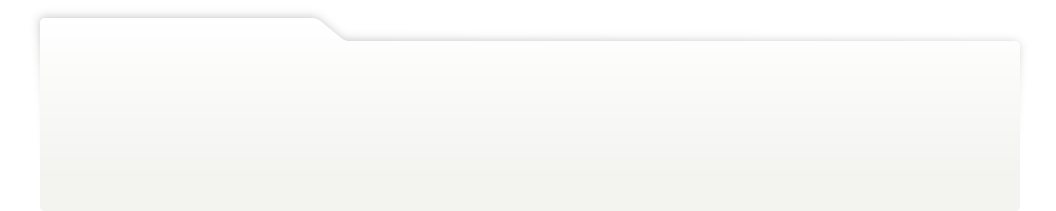
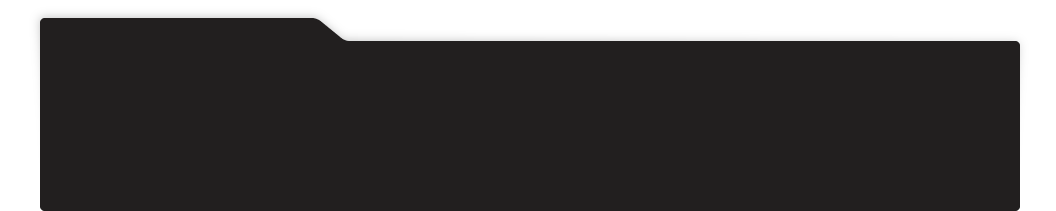
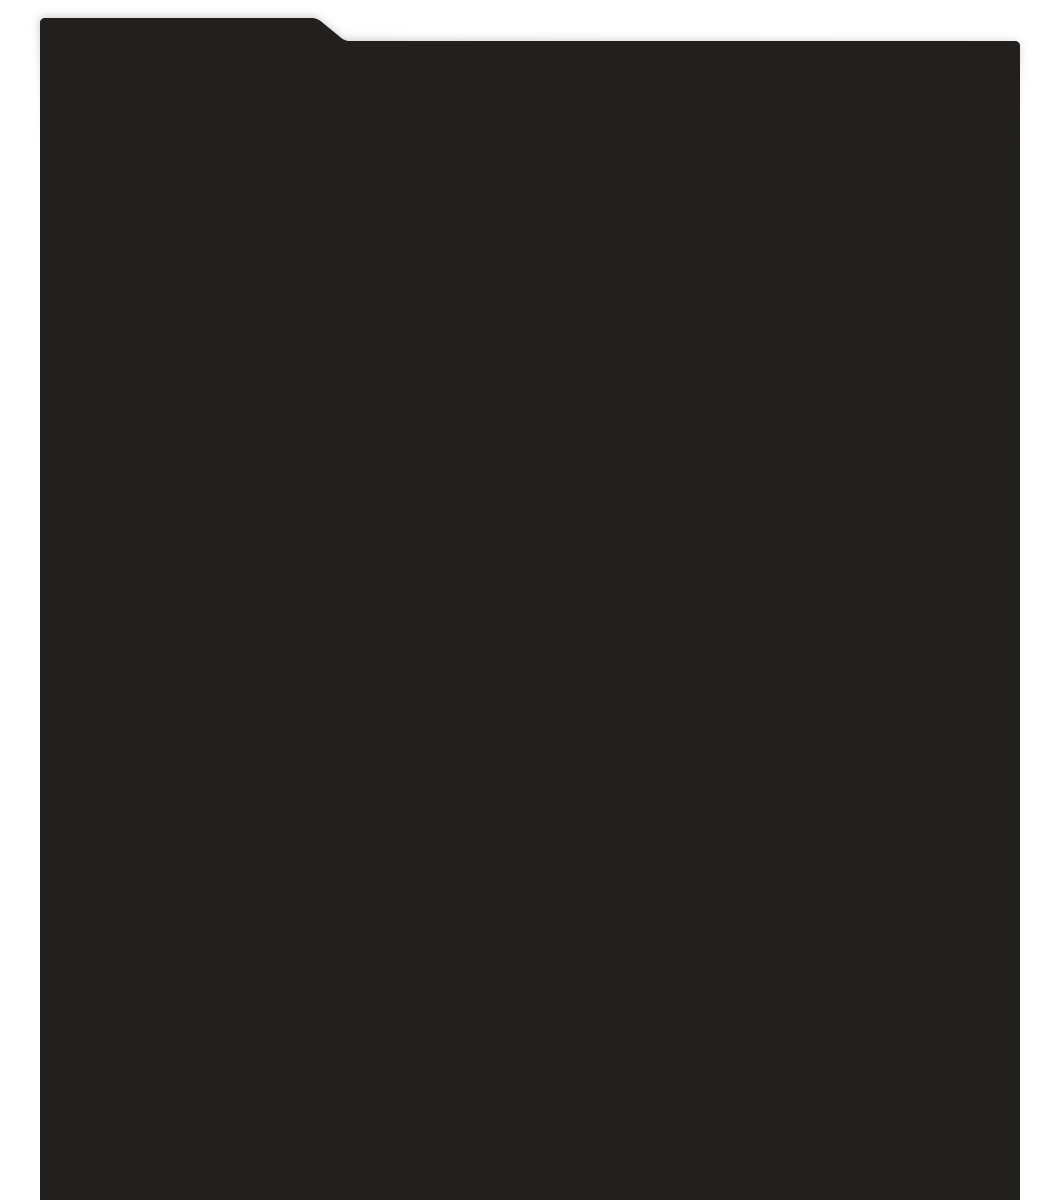
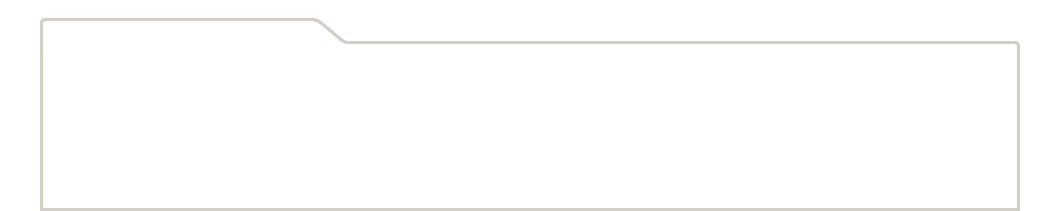
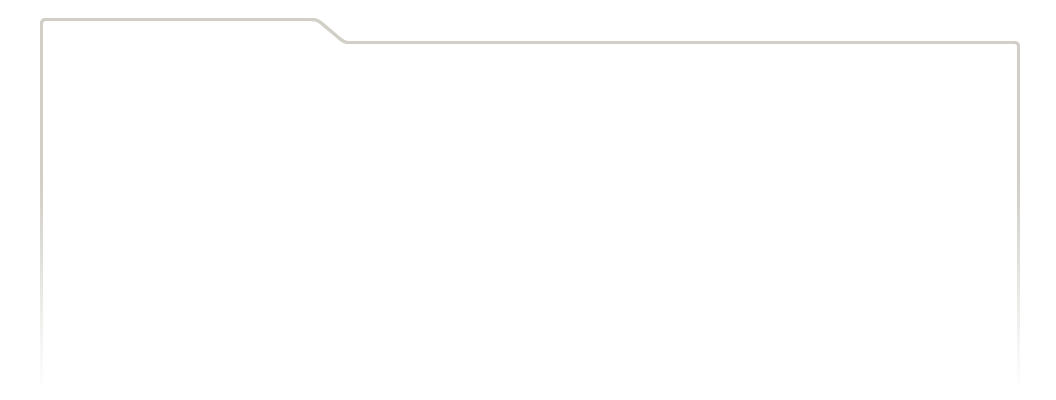
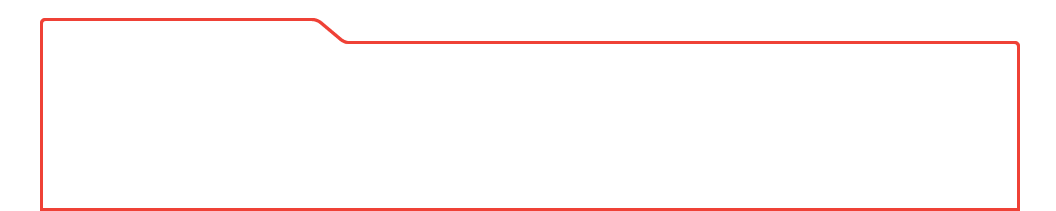
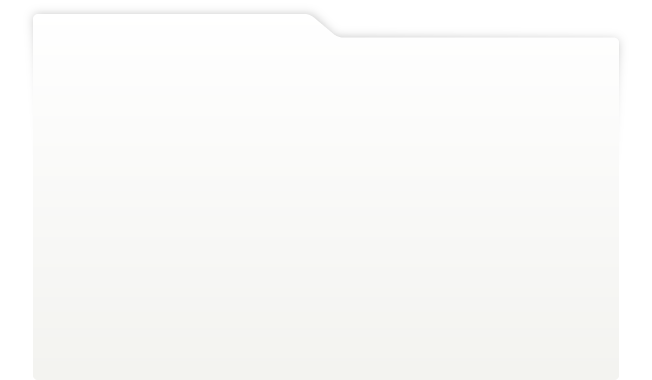
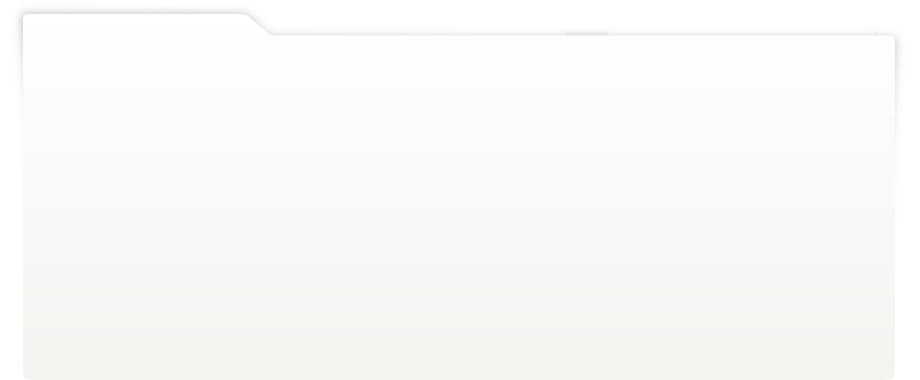
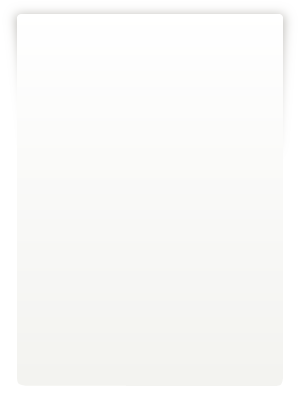
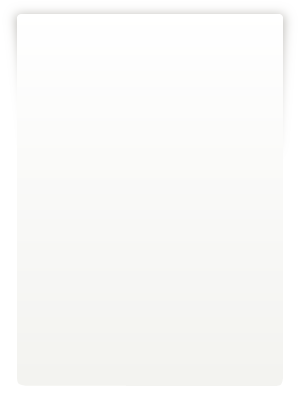
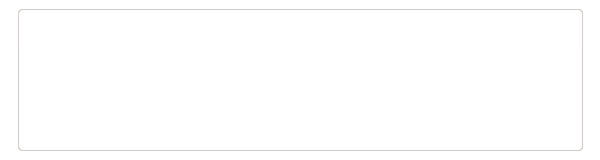
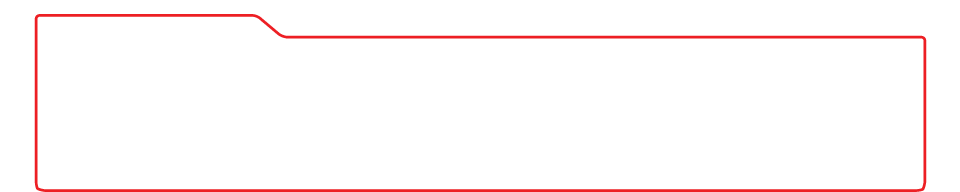
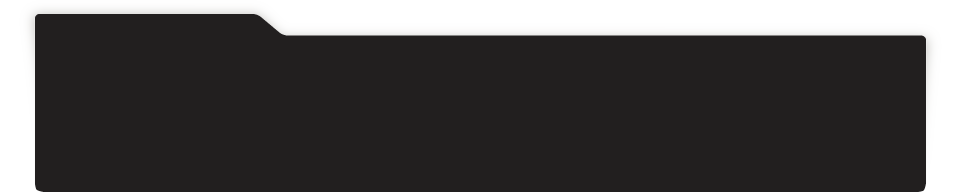
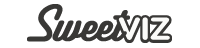
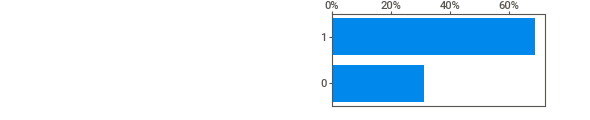
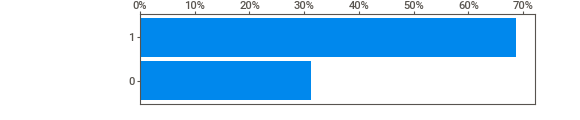
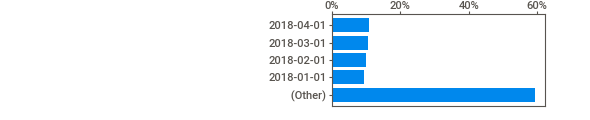
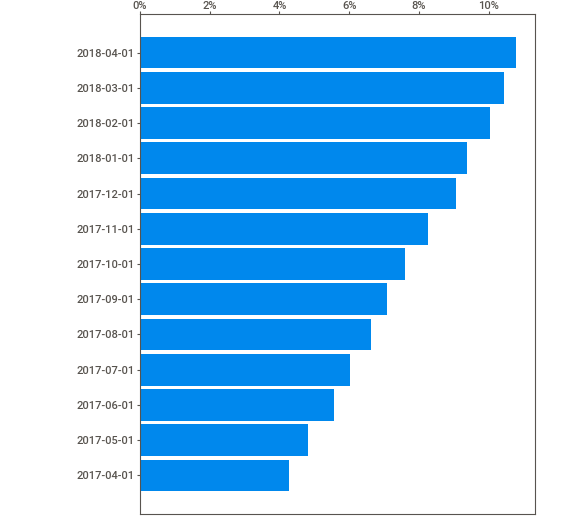
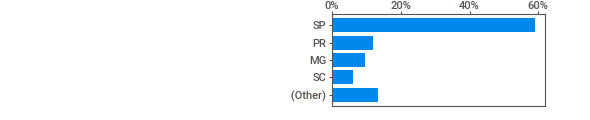
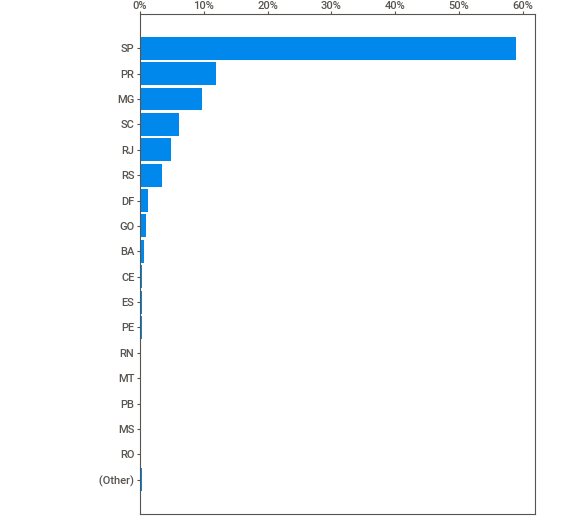
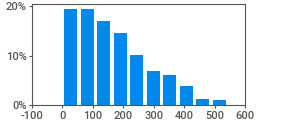
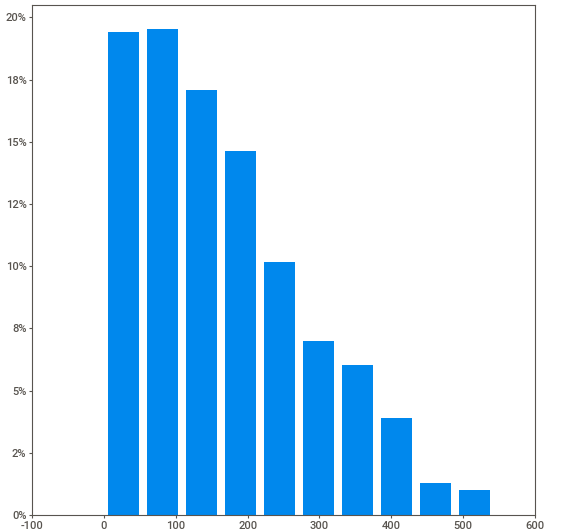
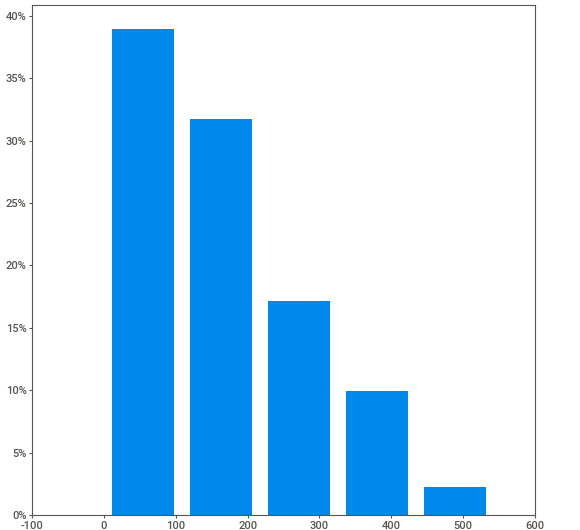
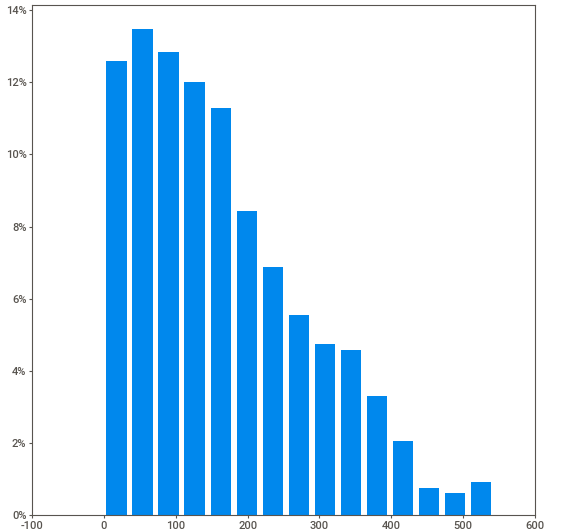
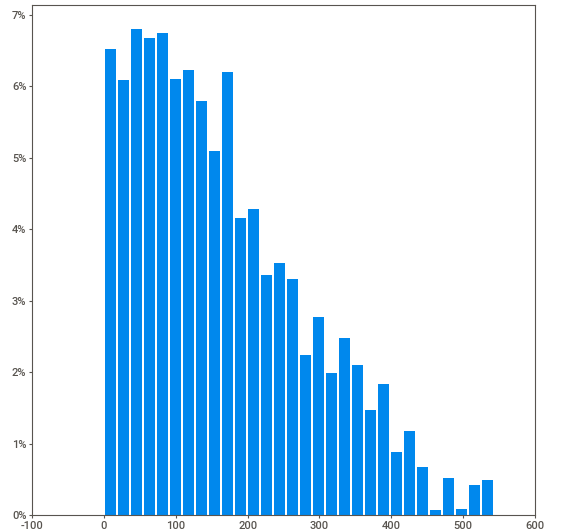
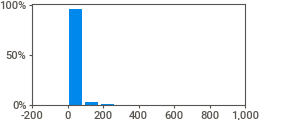
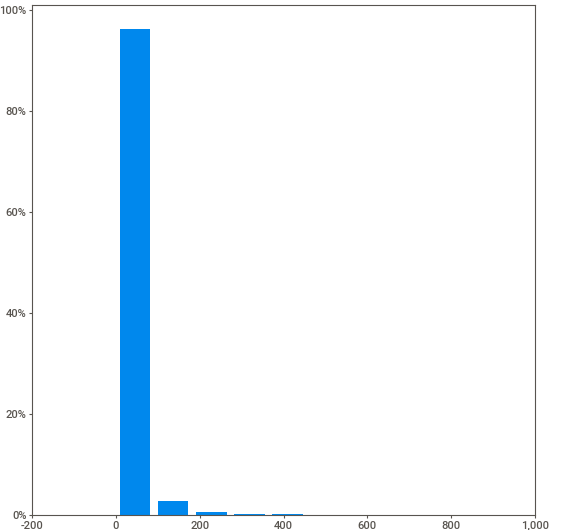
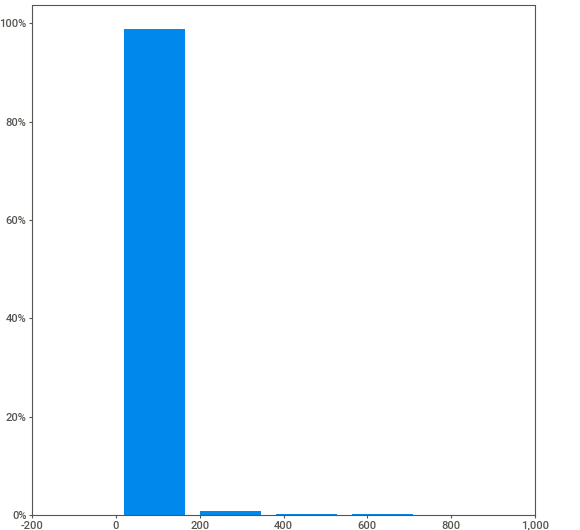
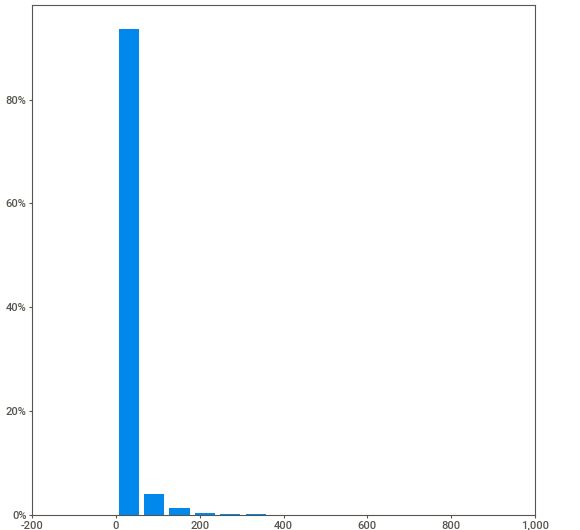
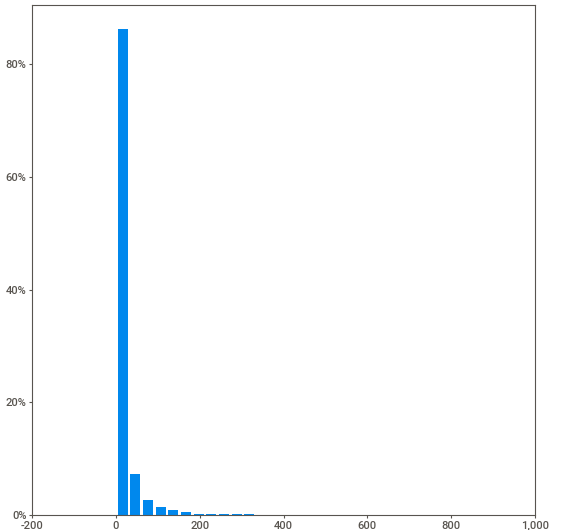
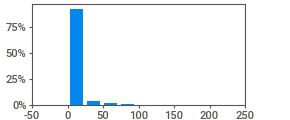
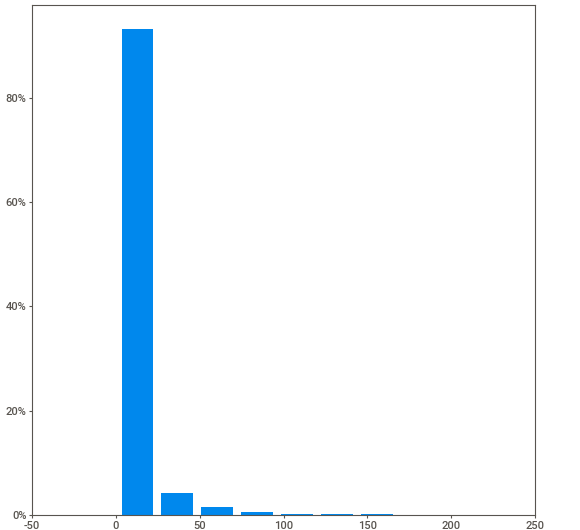
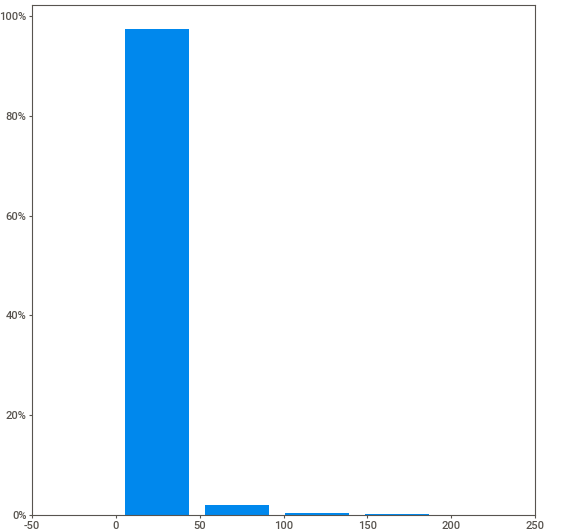
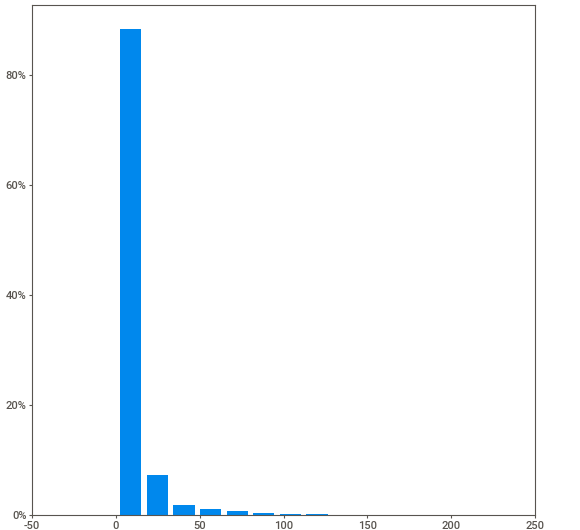
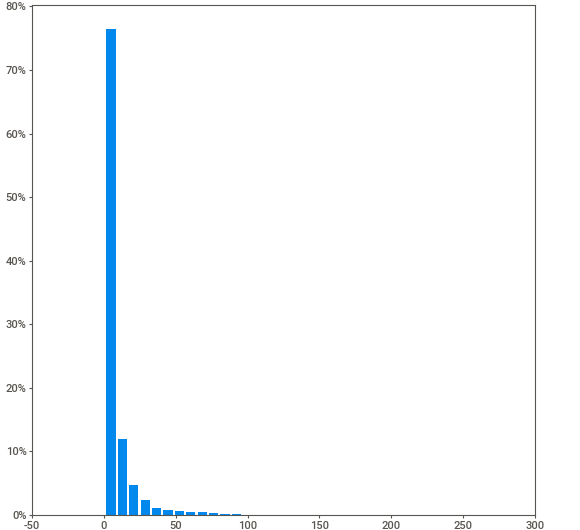
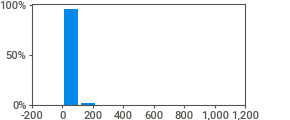
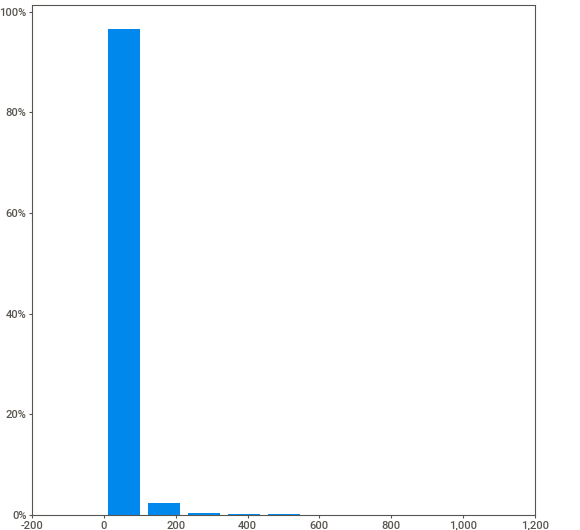
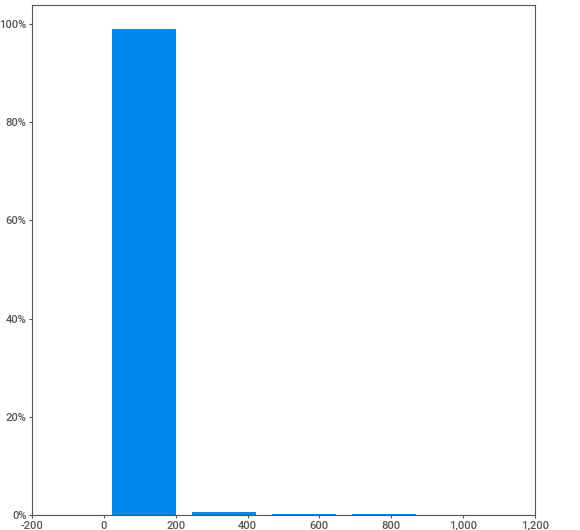
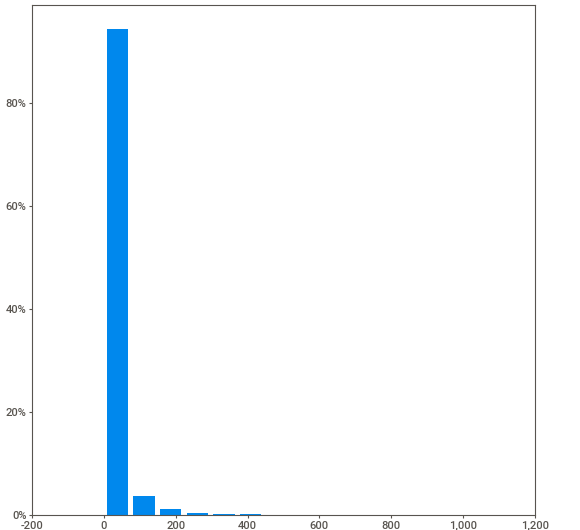
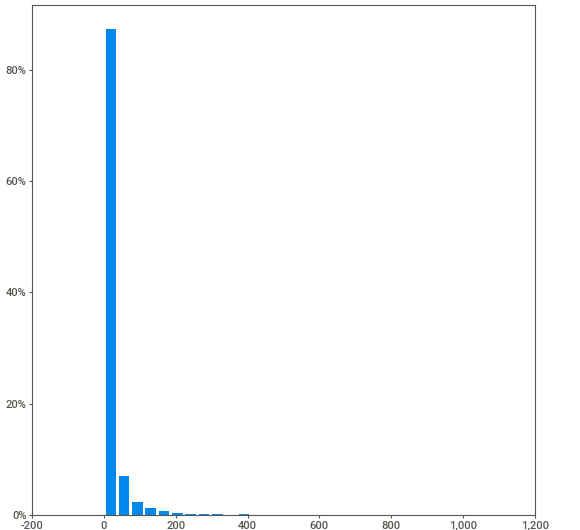
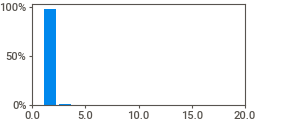
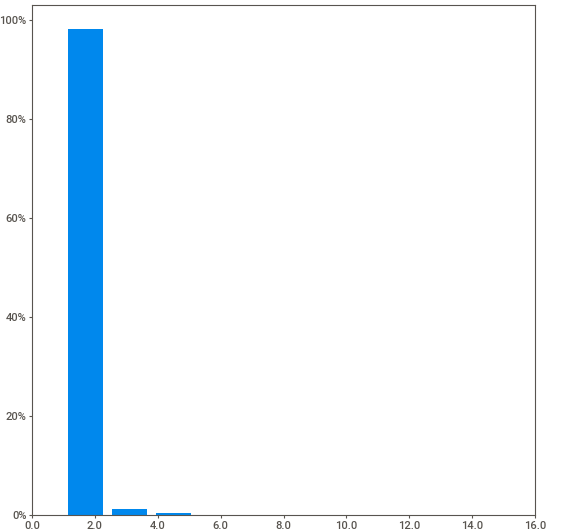
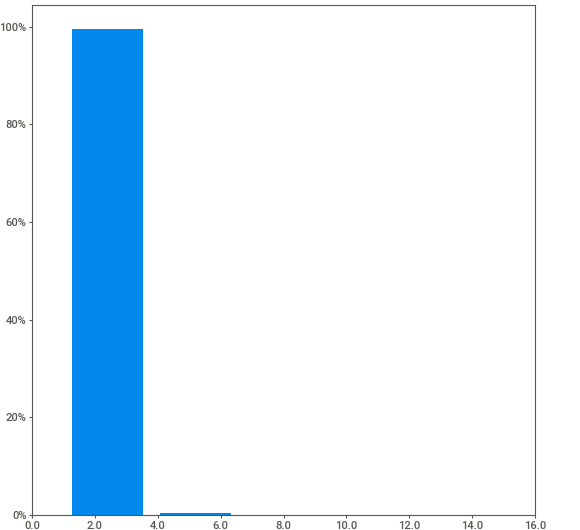
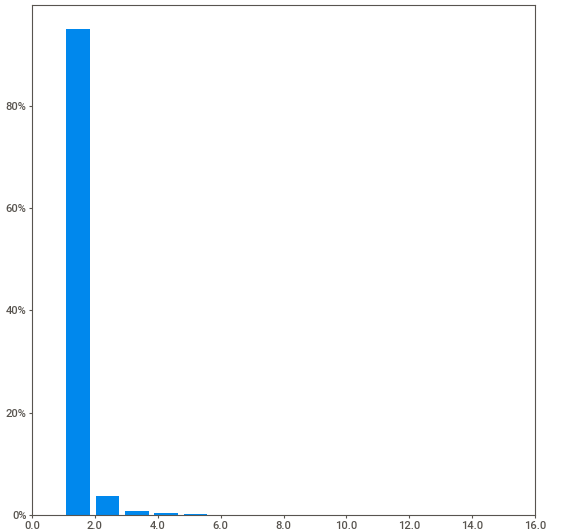
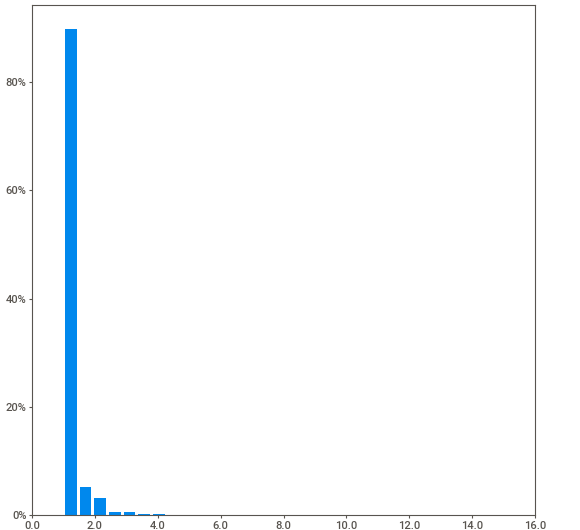
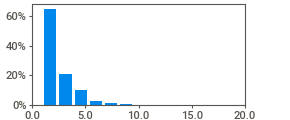
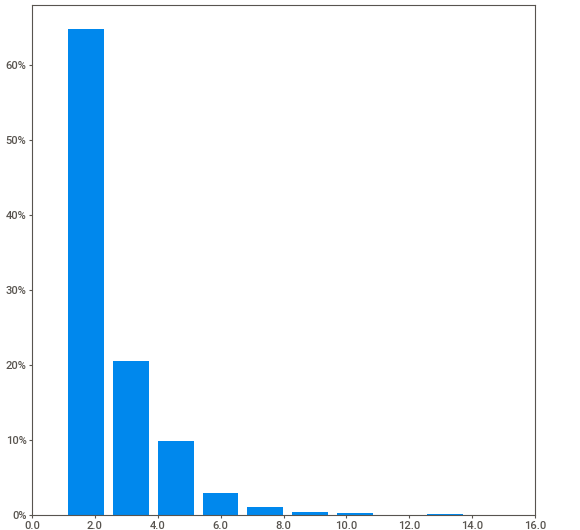
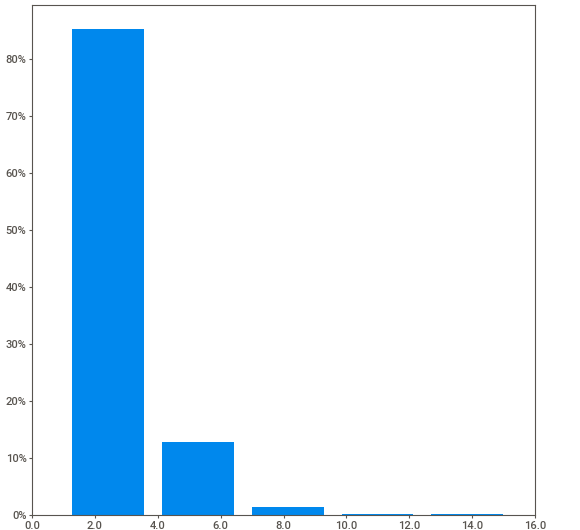
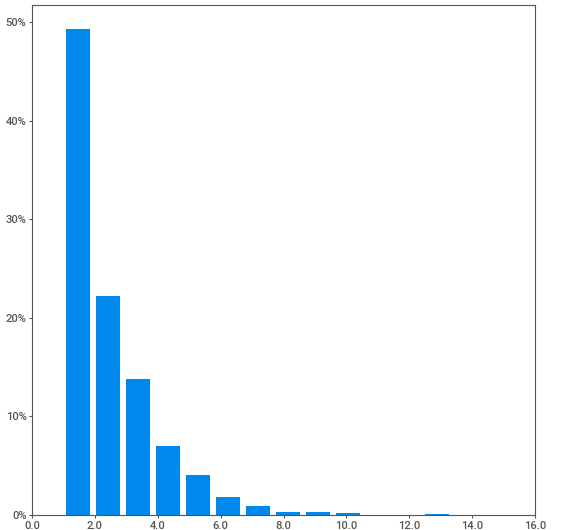
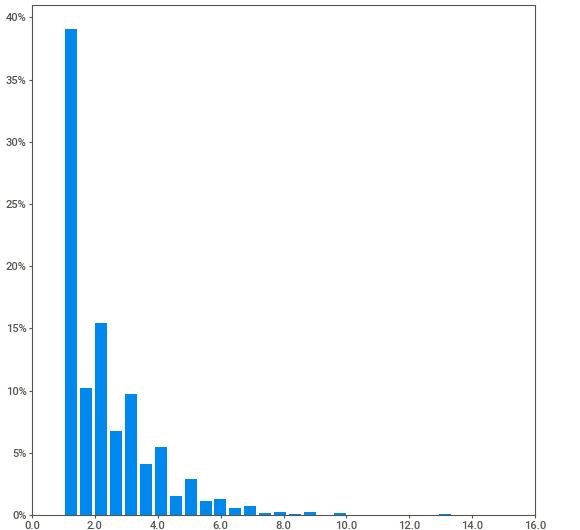
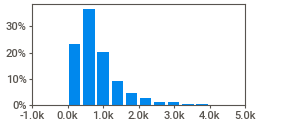
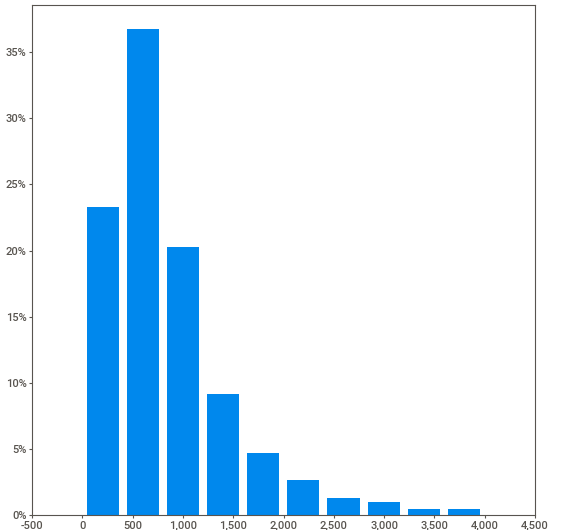
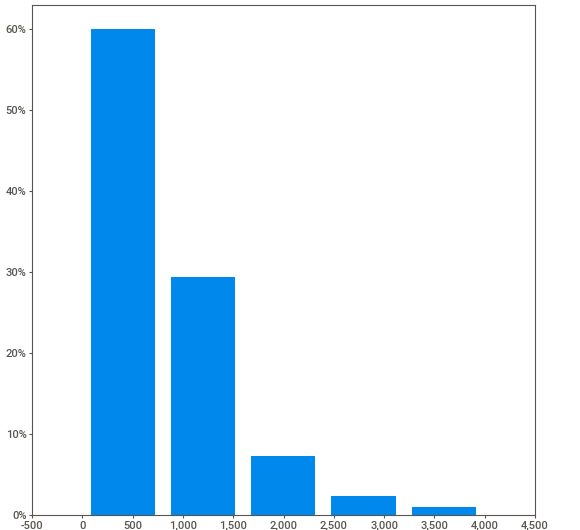
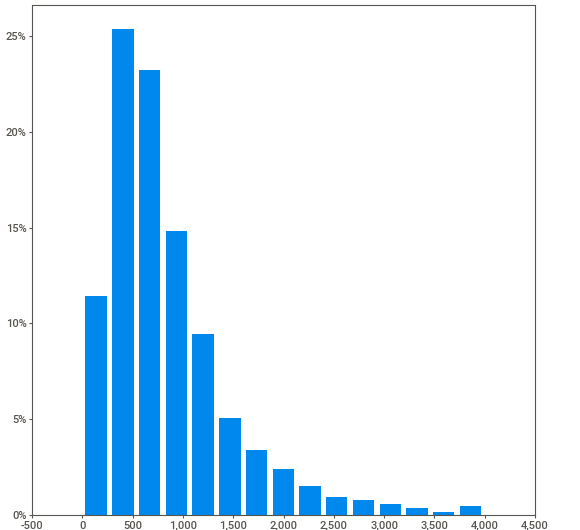
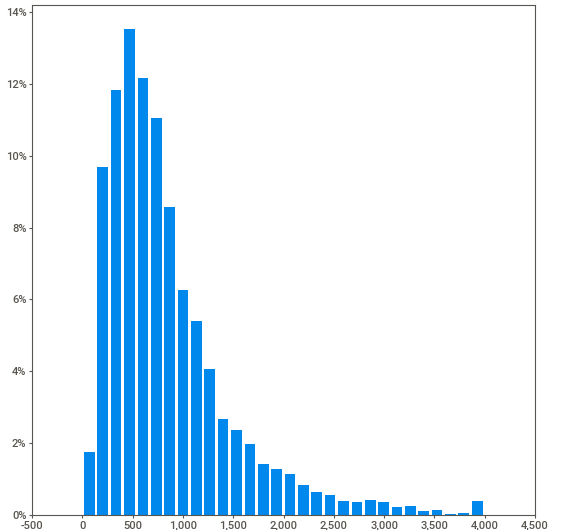
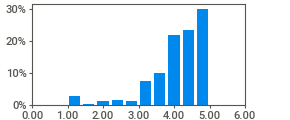
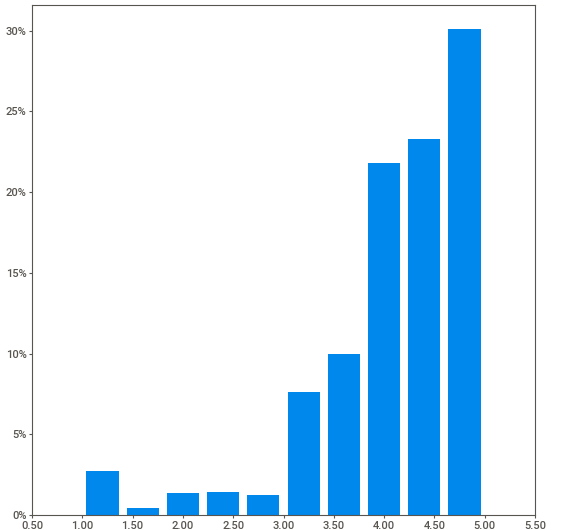
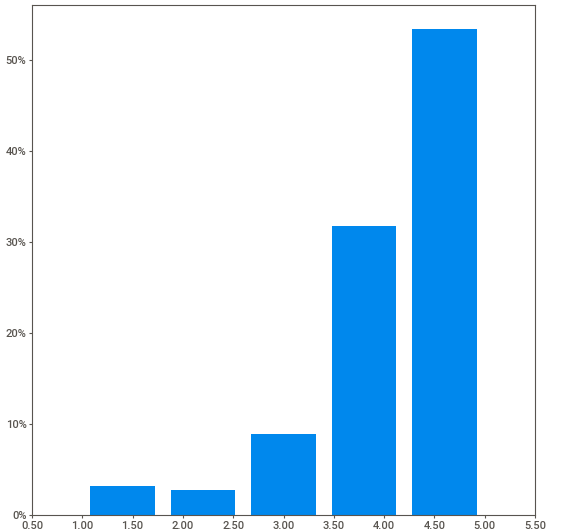
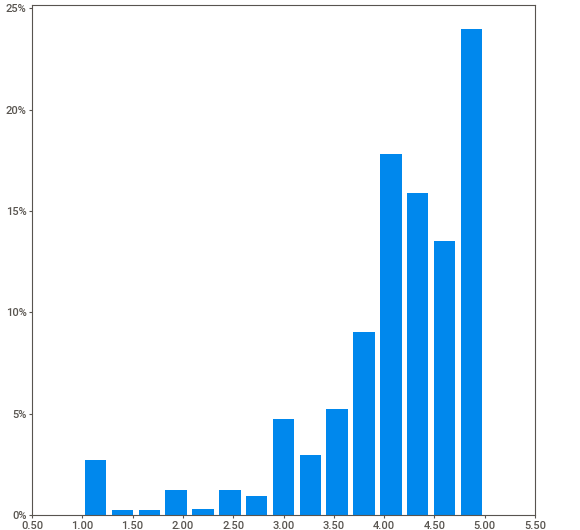
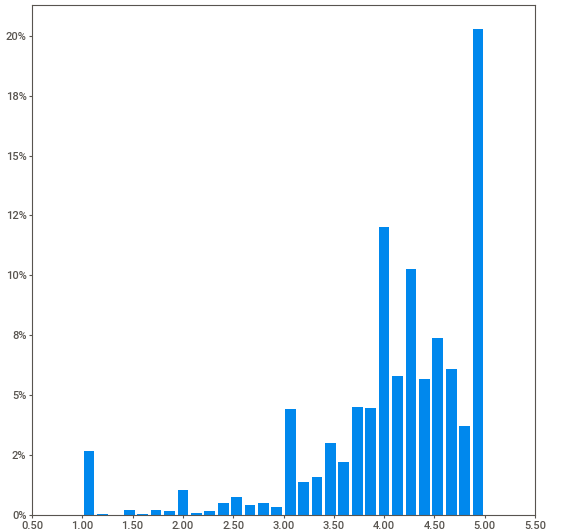
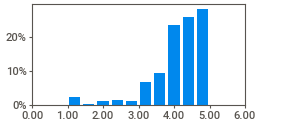
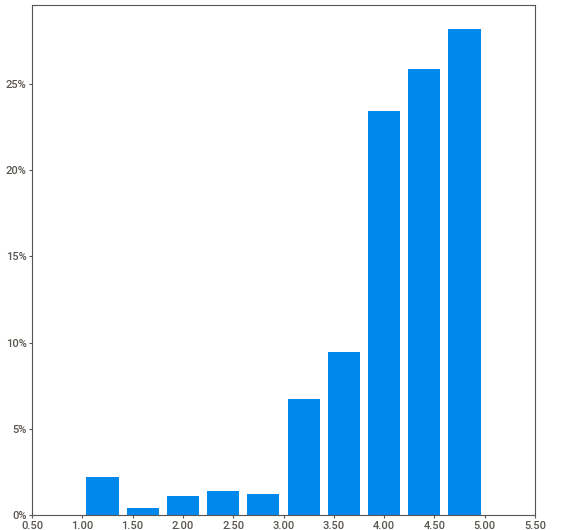
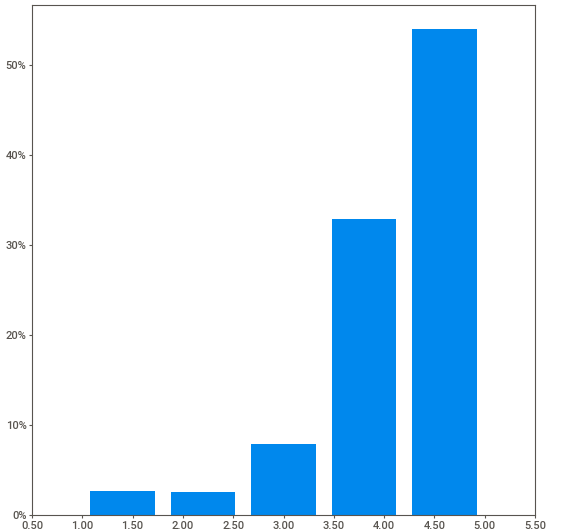
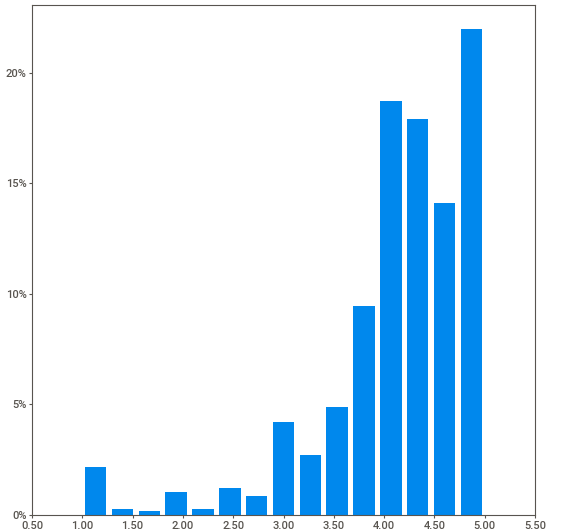
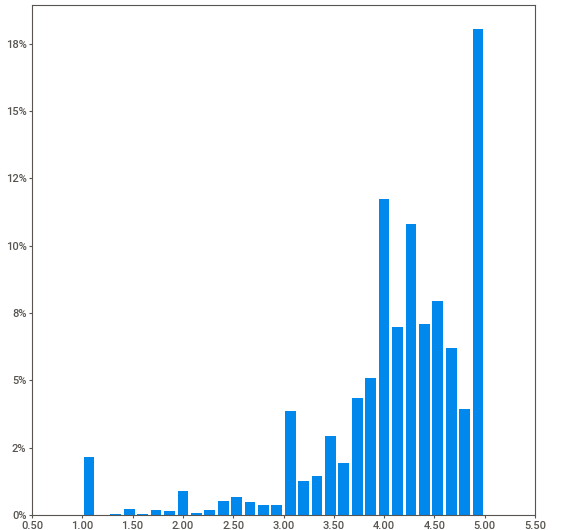
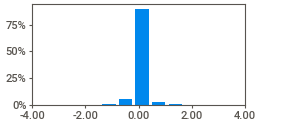
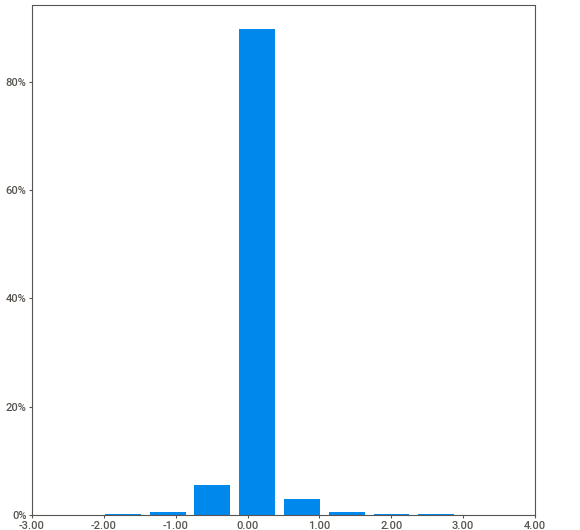
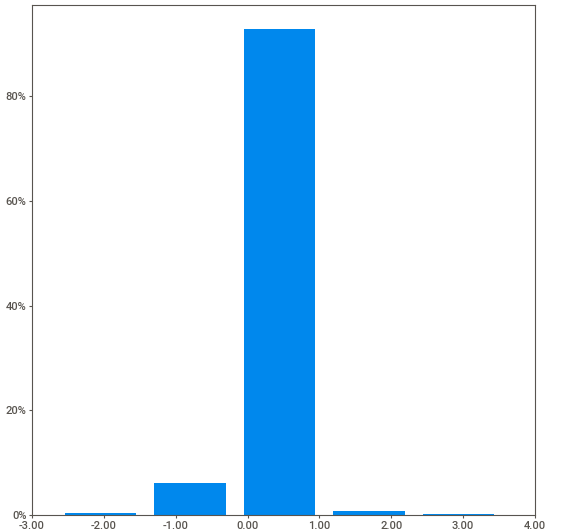
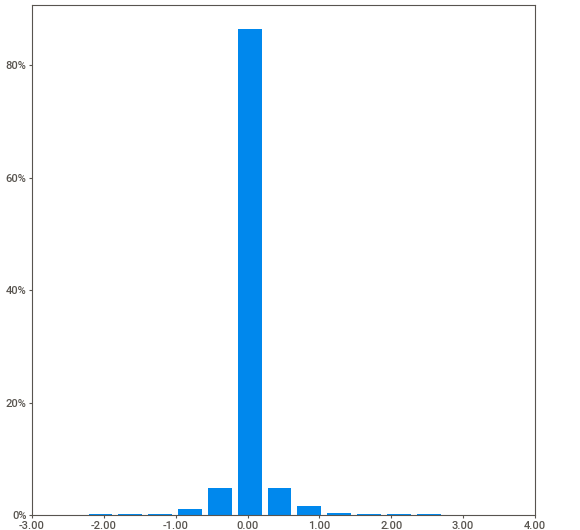
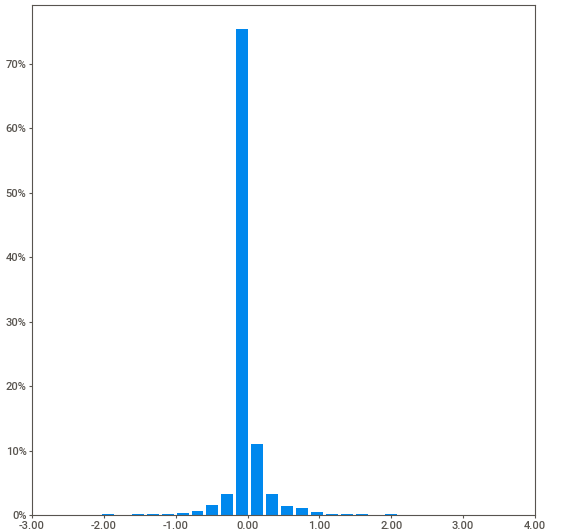
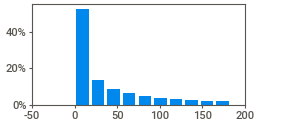
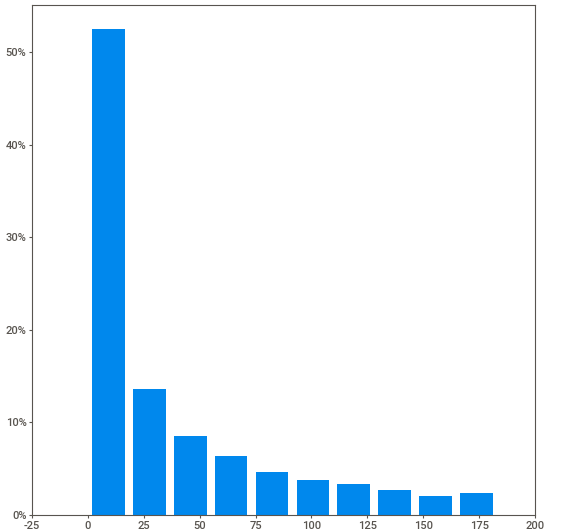
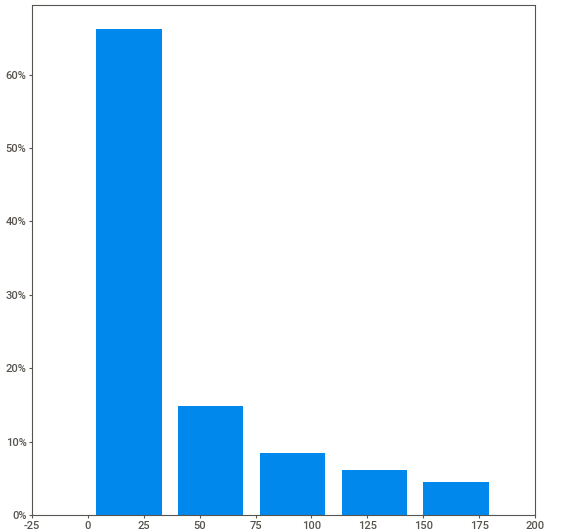
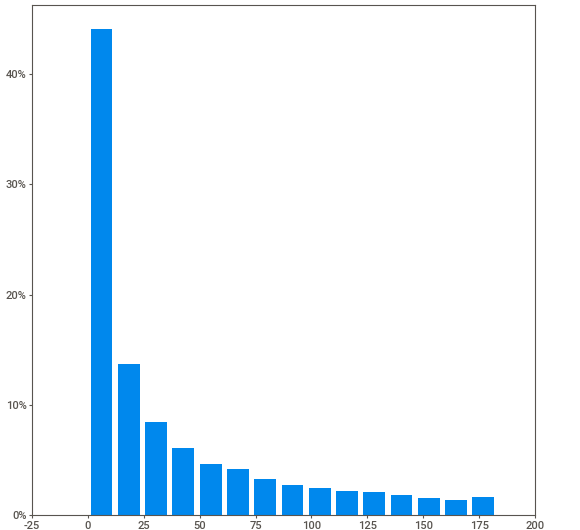
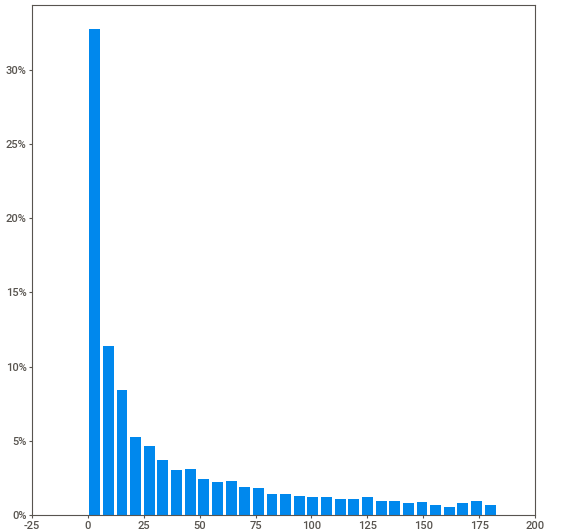
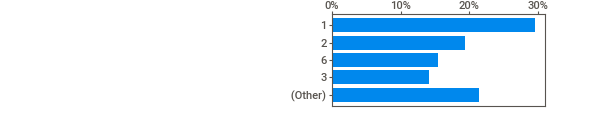
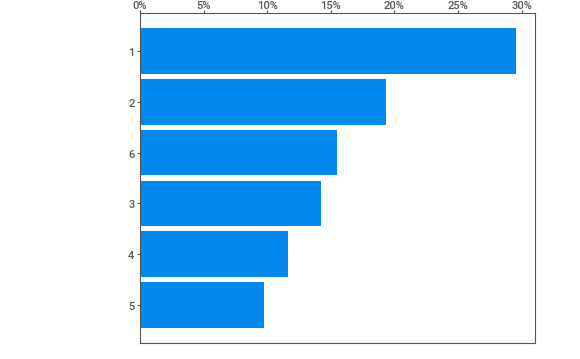
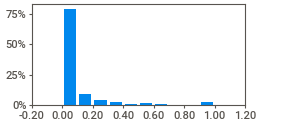
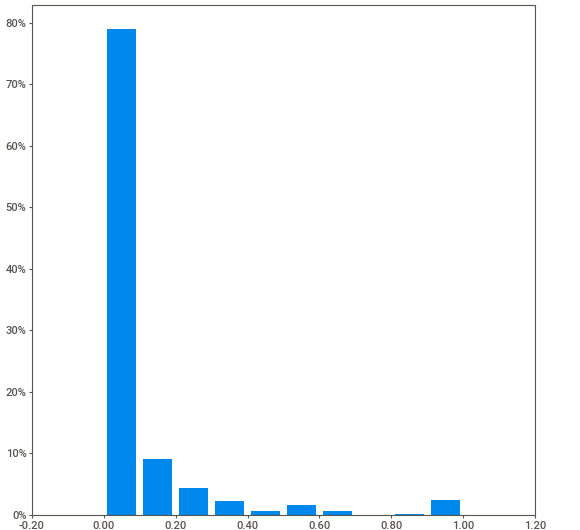
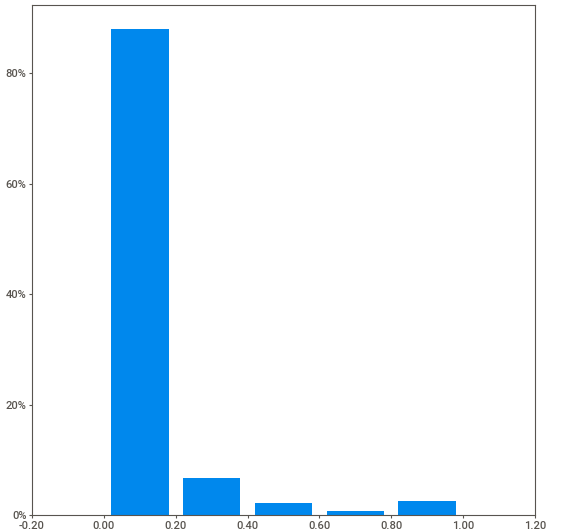
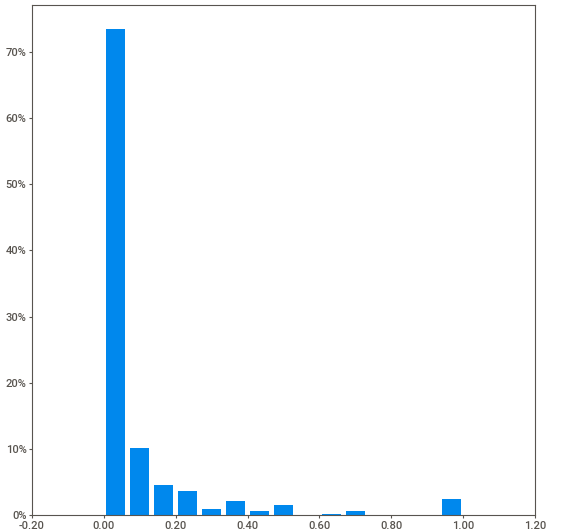
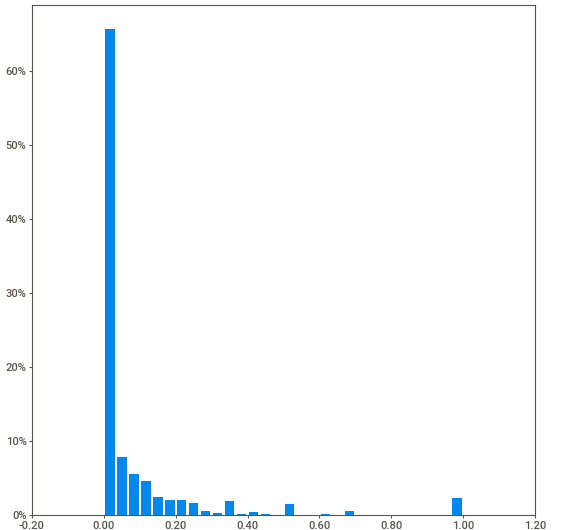
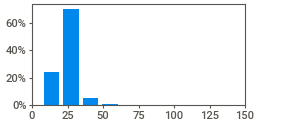
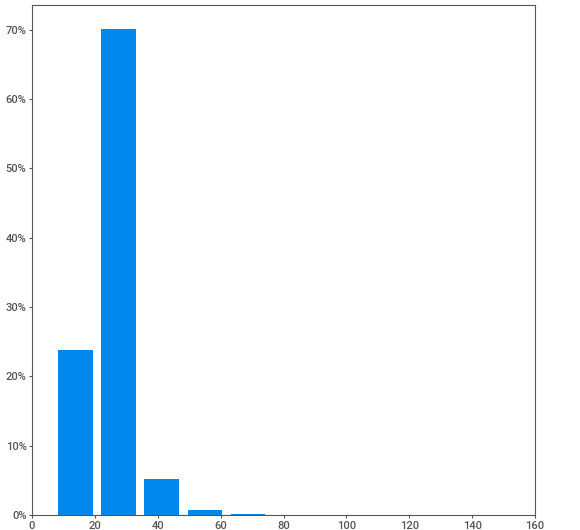
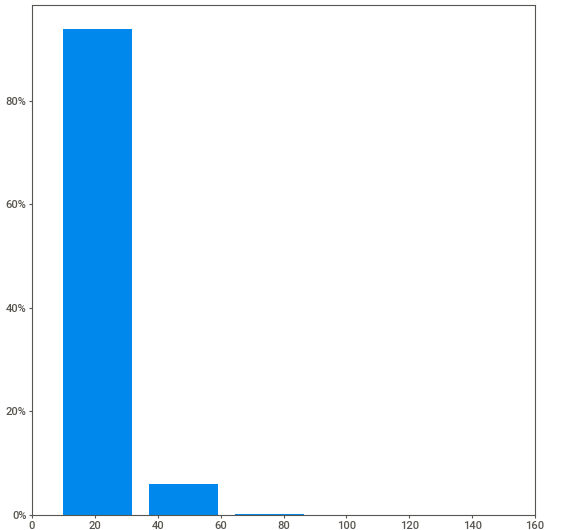
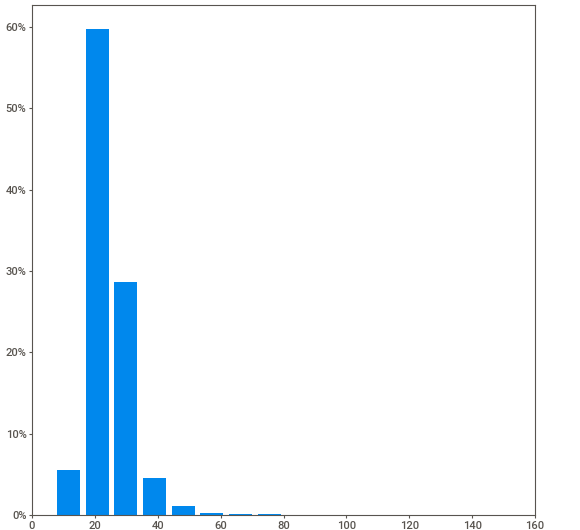
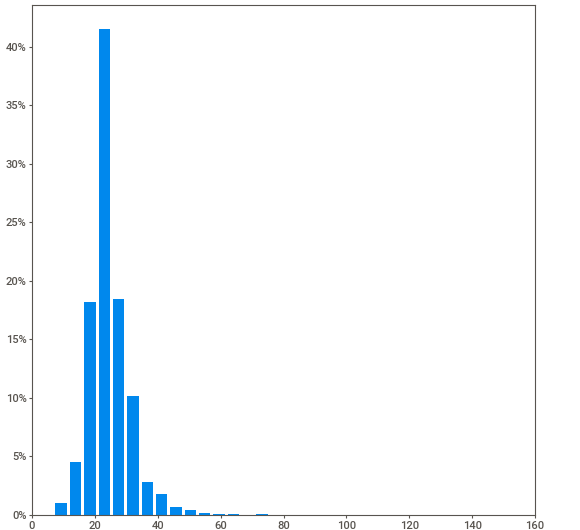
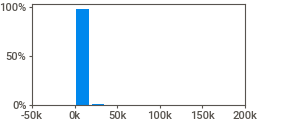
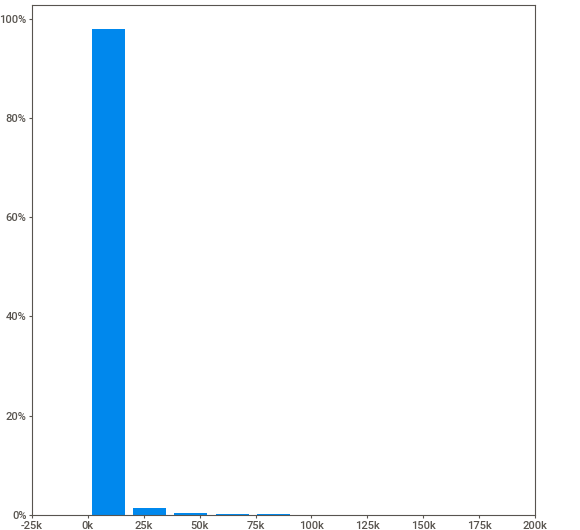
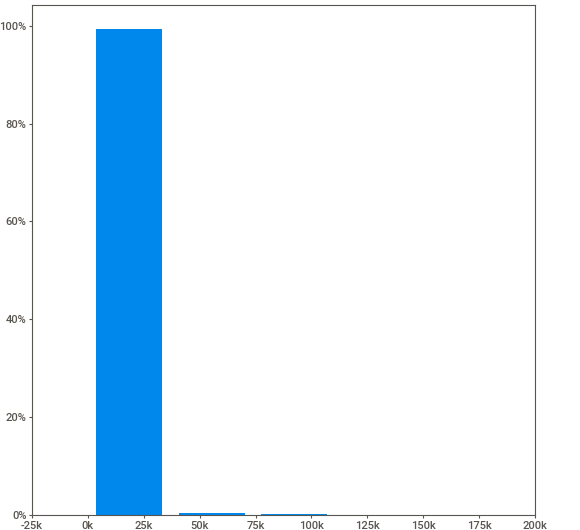
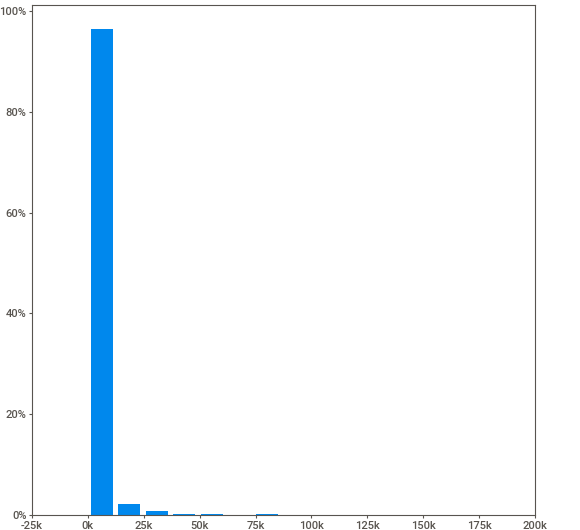
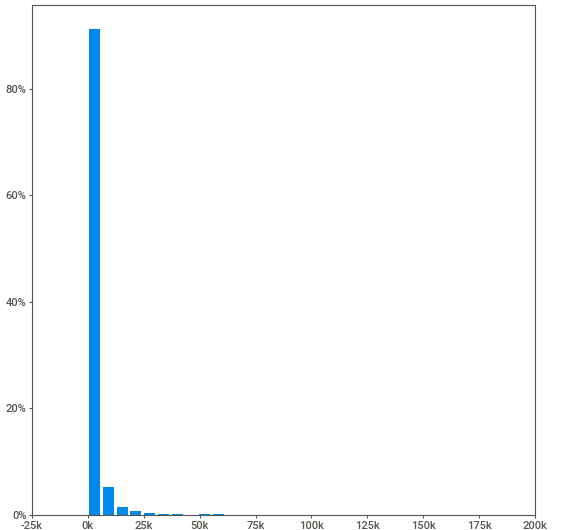
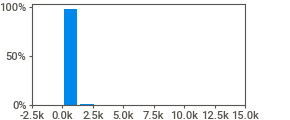
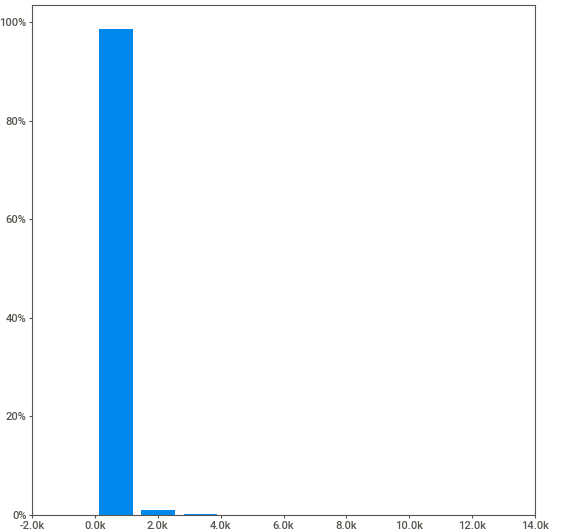
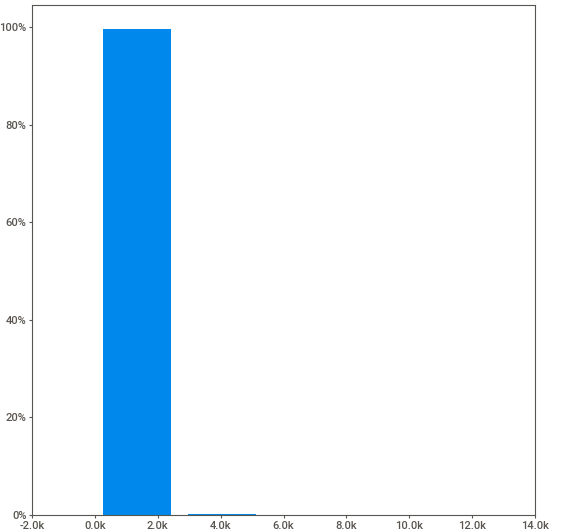
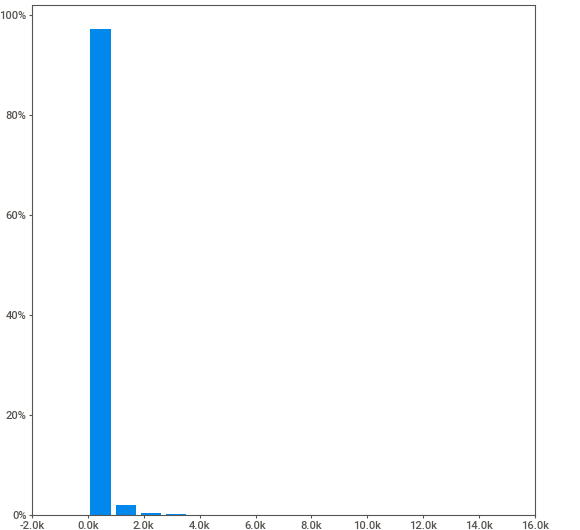
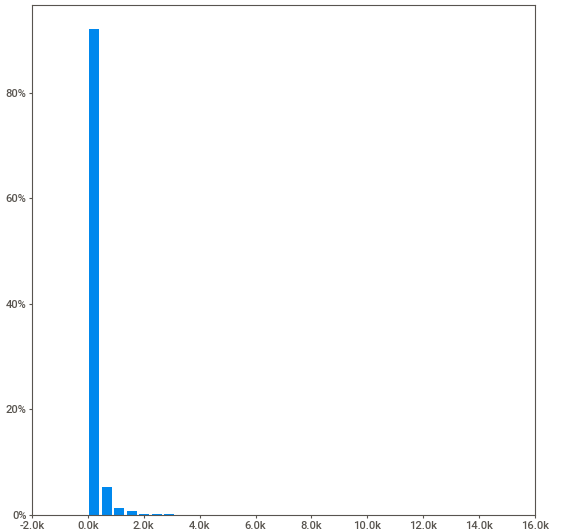
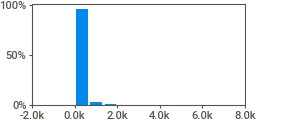
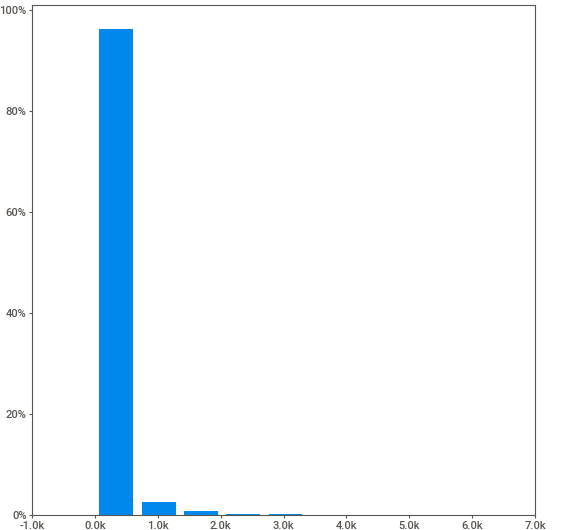
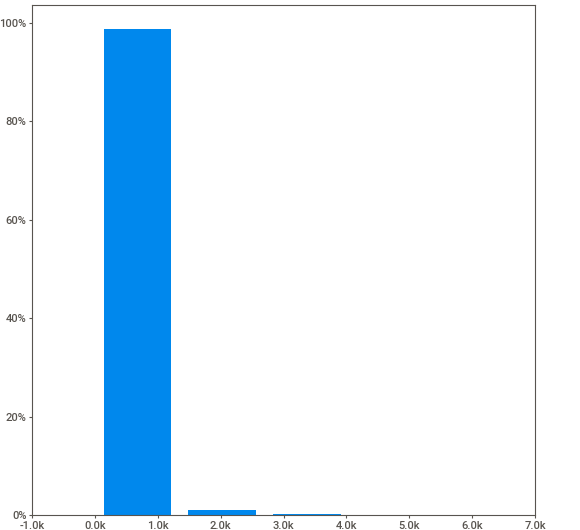
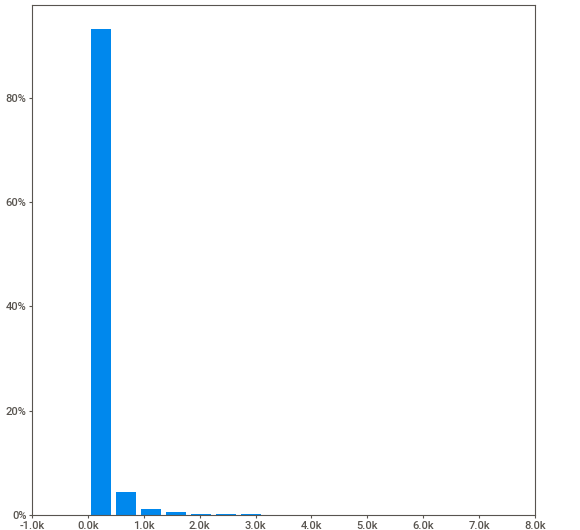
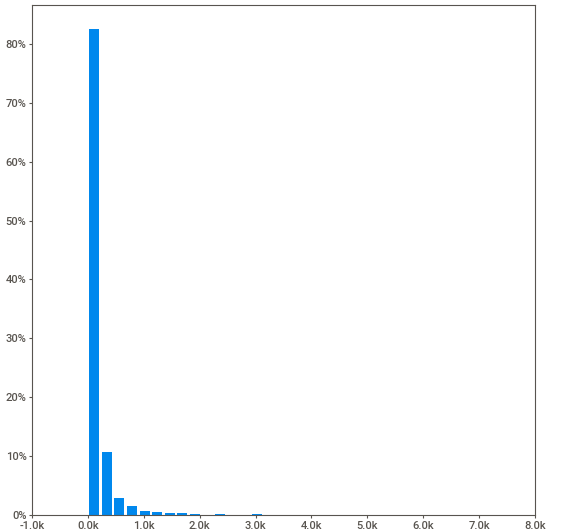
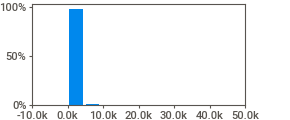
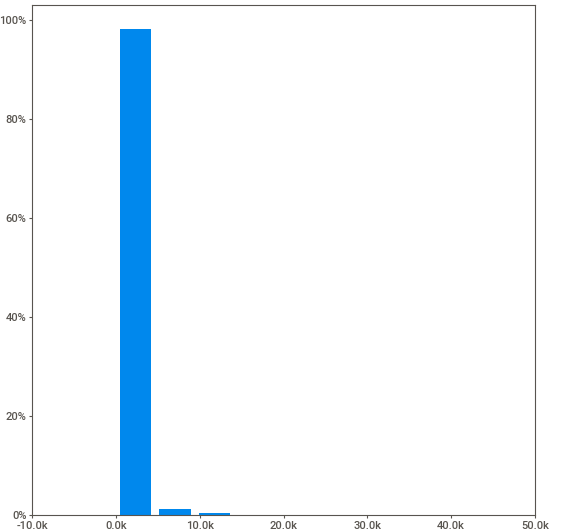
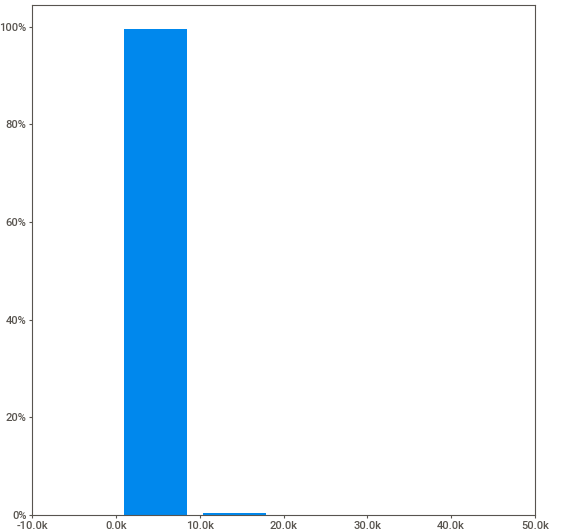
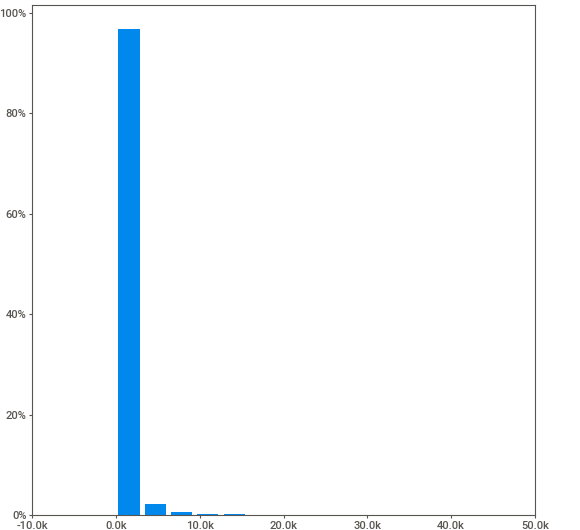
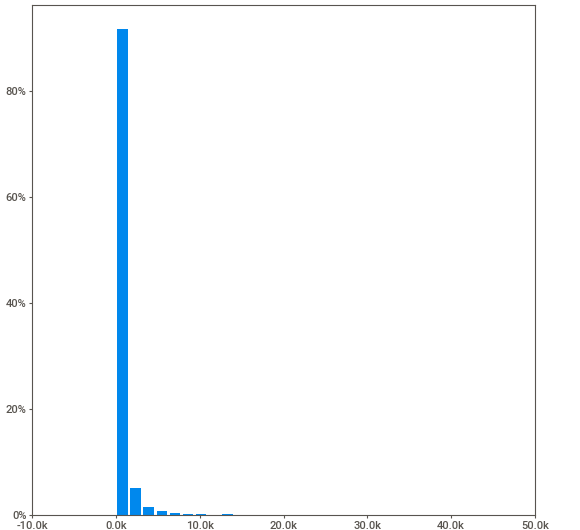
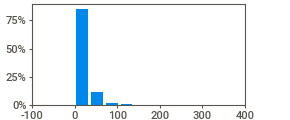
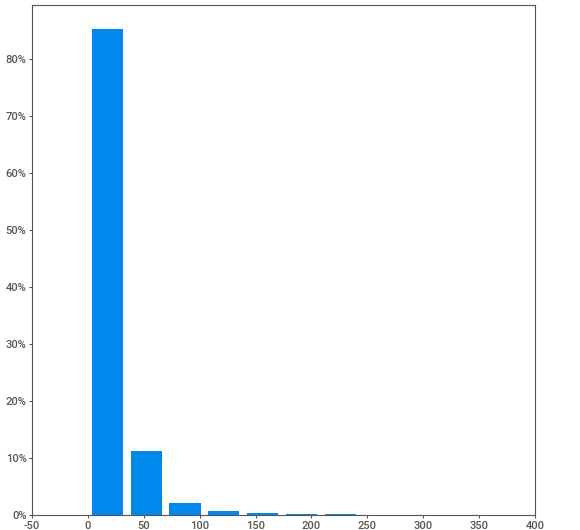
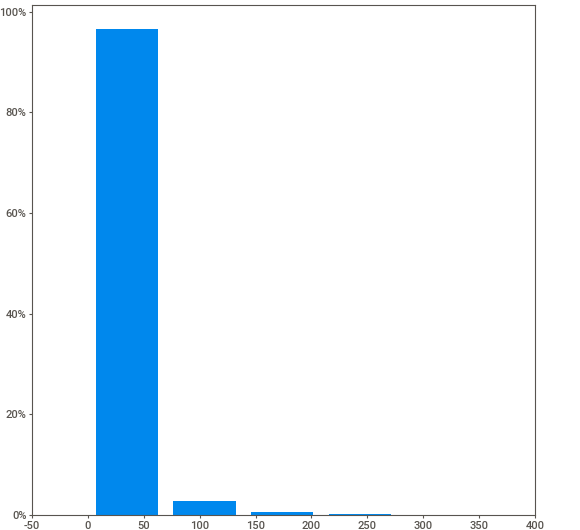
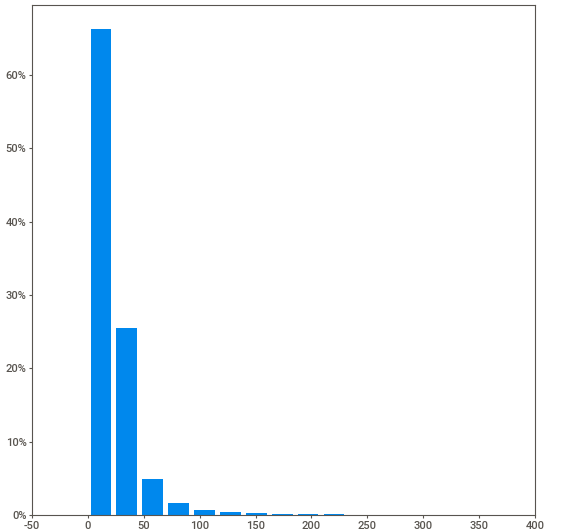
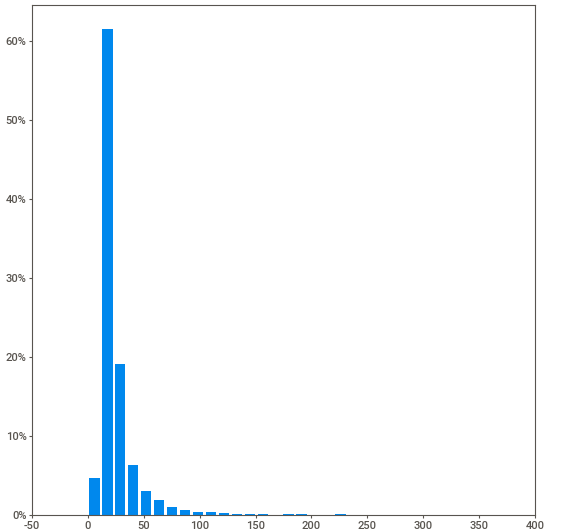
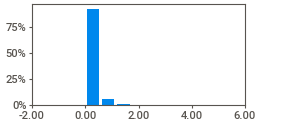
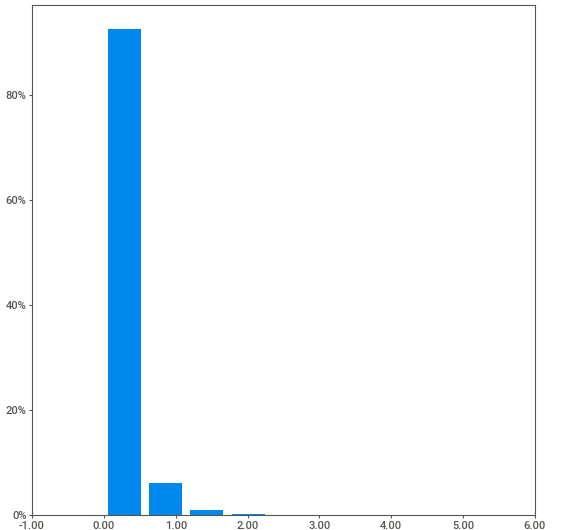
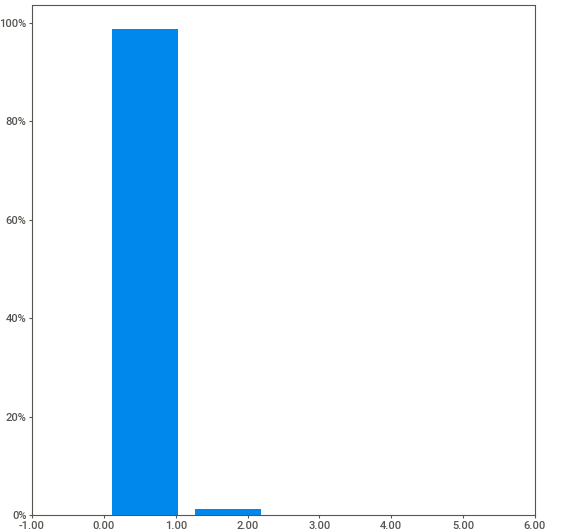
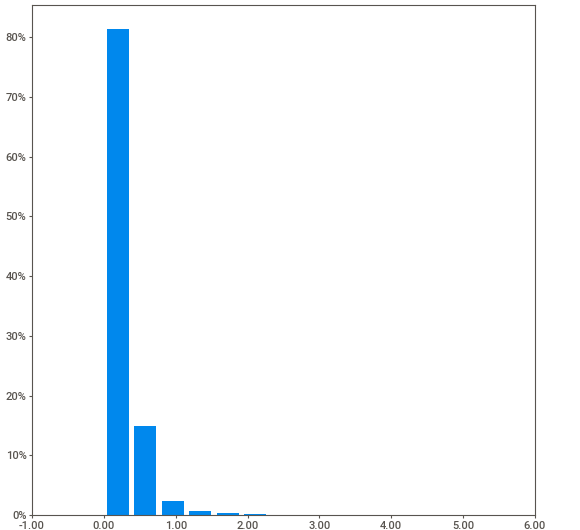
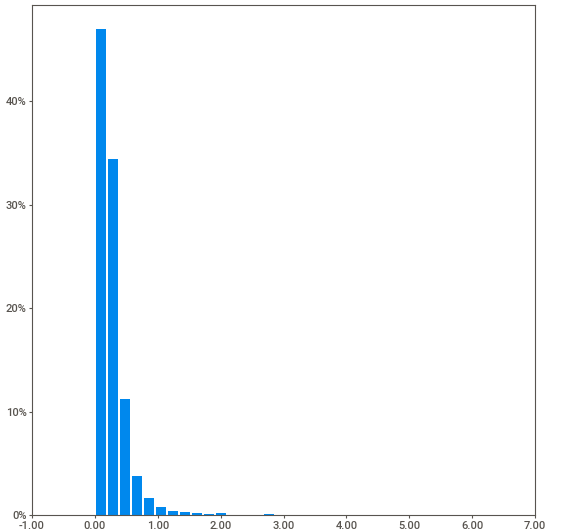
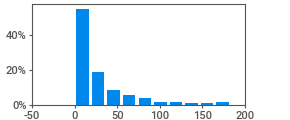
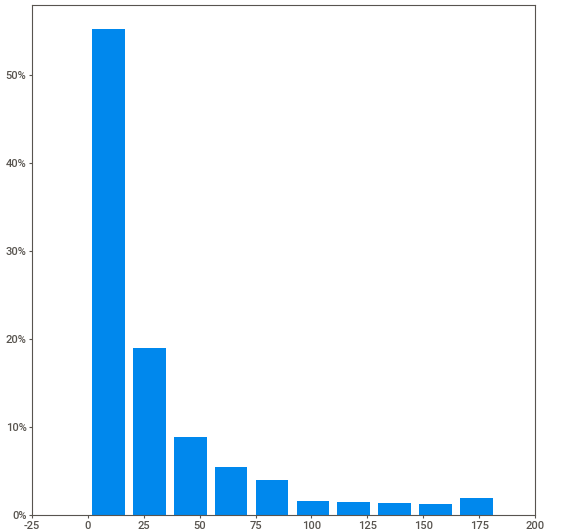
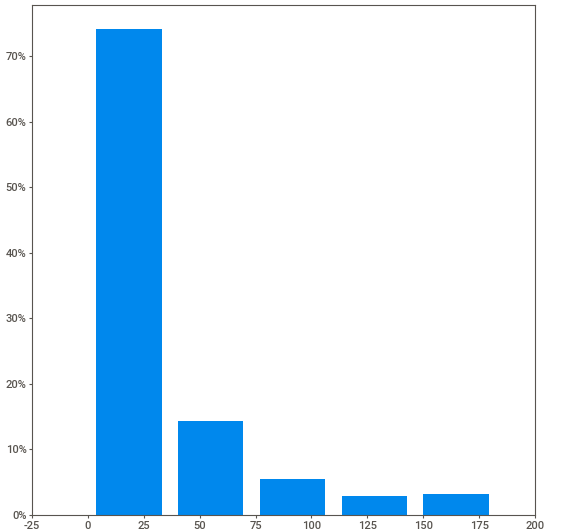
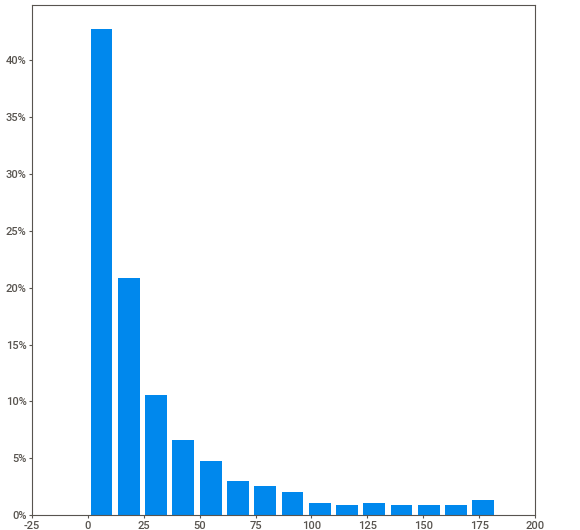
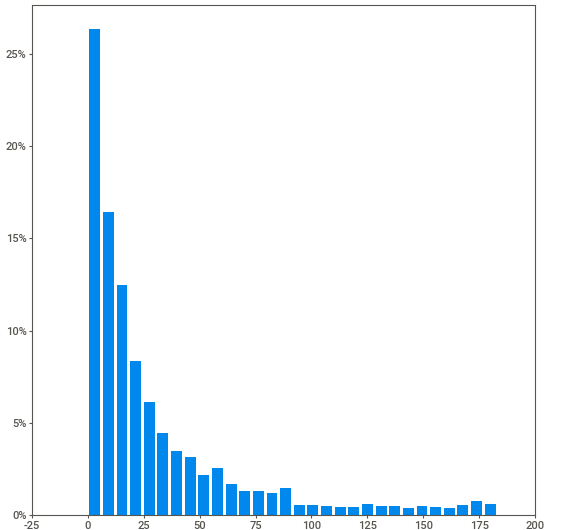
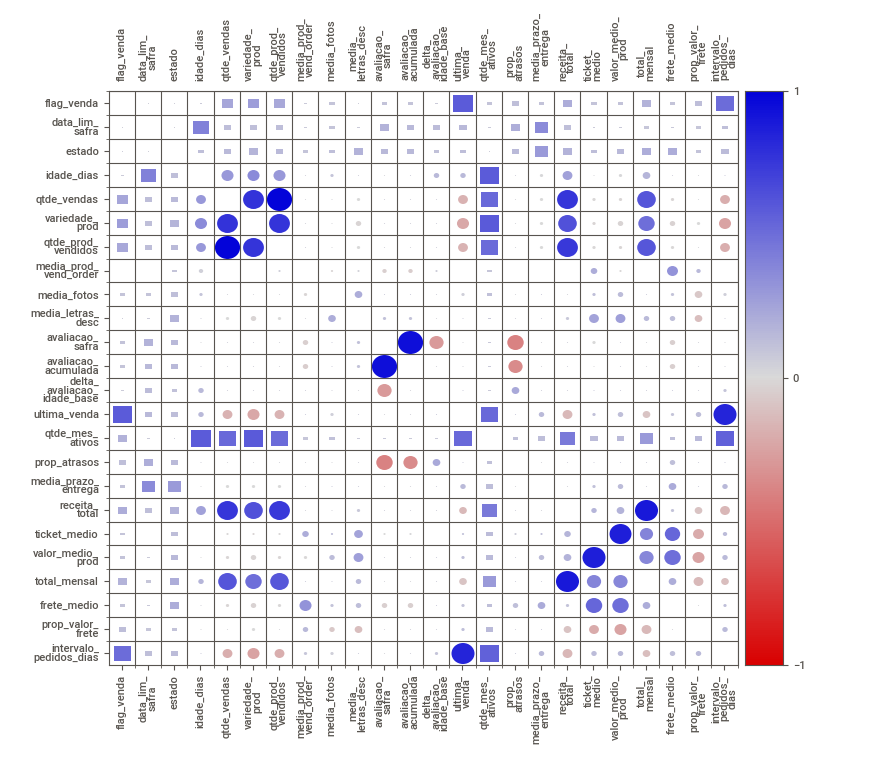
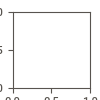

In [134]:
# Carregando o relatório através do SweetViz
# Alguns valores nulos foram encontrados e que serão substituidos pela mediana
report = sv.analyze(df)
report.show_notebook()



## Definição da Pipeline *para as variáveis*

Para as variáveis numéricas será aplicado o Simple Imputer substituindo os valores pela mediana e posteriormente aplicando o MinMax Scaler para o pre-processamento.
Para as variáveis categóricas será aplicado o One Hot Encoder


In [121]:
# Separando as features entre categóricas e numéricas

cat_features = df[features].dtypes[df[features].dtypes == 'object'].index.tolist()
num_features = df[features].dtypes[df[features].dtypes !='object'].index.tolist()

num_enc = Pipeline([('imputer' , SimpleImputer(missing_values= np.nan , strategy='median')),
                    ('scaler', MinMaxScaler())])
preparation = ColumnTransformer( transformers= [    ('numeric', num_enc, num_features),
                                                    ('categorical' , OneHotEncoder(handle_unknown = 'ignore'), cat_features)])

## Definição dos Algoritmos de Machine Learning
Selecionando alguns algoritmos para verificar os resultados de cada um deles

In [122]:
algoritmos = [ 
                # Tree
                tree.DecisionTreeClassifier(),
                tree.ExtraTreeClassifier(),
                # SVM
                svm.LinearSVC(),
                # Neighbors
                neighbors.KNeighborsClassifier(),
                # Naive Bayes
                naive_bayes.BernoulliNB(),
                naive_bayes.GaussianNB(),
                # GLM
                linear_model.LogisticRegression(),
                linear_model.RidgeClassifier(),
                linear_model.SGDClassifier(),
                linear_model.Perceptron(),
                # Ensemble Methods
                ensemble.AdaBoostClassifier(),
                ensemble.BaggingClassifier(),
                ensemble.GradientBoostingClassifier(),
                ensemble.ExtraTreesClassifier(),
                ensemble.RandomForestClassifier()]

## Validação Cruzada com os Algoritmos a serem usados nas Pipelines


In [123]:
#Criando um Dataframe com os resultados assim pode-se comparar os resultados

MLA_cols = ["MLA Name", "MLA Parameters", "MLA Train ROC_AUC Mean", "MLA Test ROC_AUC Mean", "MLA Test ROC_AUC DV Pad", "MLA Time"]
MLA_Compare = pd.DataFrame(columns=MLA_cols)
row_index = 0 # set index

# A métrica utilizada para escolha do melhor algoritmo será a ROC AUC

cv_split = ShuffleSplit(random_state=123)
for algoritmo in algoritmos:
    pipe_loop = Pipeline([  ('prep' , preparation),
                            ('alg' , algoritmo)])
    MLA_name = pipe_loop['alg'].__class__.__name__ # Name of the Algorithm
    print(f"Processando o algoritmo {MLA_name}") 
    MLA_Compare.loc[row_index,"MLA Name"]  = MLA_name
    MLA_Compare.loc[row_index, "MLA Parameters"] = str(pipe_loop['alg'].get_params())
    cv_results = cross_validate(pipe_loop, X= X_train, y= y_train, cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')
    #Resultados da validação cruzada
    MLA_Compare.loc[row_index, "MLA Time"] = cv_results['fit_time'].mean()
    MLA_Compare.loc[row_index, "MLA Train ROC_AUC Mean"] = cv_results['train_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC Mean"] = cv_results['test_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC DV Pad"] = cv_results['test_score'].std()*3
    row_index +=1

MLA_Compare.sort_values(by="MLA Test ROC_AUC Mean", ascending=False, inplace=True , ignore_index=True)

Processando o algoritmo DecisionTreeClassifier
Processando o algoritmo ExtraTreeClassifier
Processando o algoritmo LinearSVC
Processando o algoritmo KNeighborsClassifier
Processando o algoritmo BernoulliNB
Processando o algoritmo GaussianNB
Processando o algoritmo LogisticRegression
Processando o algoritmo RidgeClassifier
Processando o algoritmo SGDClassifier
Processando o algoritmo Perceptron
Processando o algoritmo AdaBoostClassifier
Processando o algoritmo BaggingClassifier
Processando o algoritmo GradientBoostingClassifier
Processando o algoritmo ExtraTreesClassifier
Processando o algoritmo RandomForestClassifier


## Resultados da Validação Cruzada

Os resultados plotados no gráfico abaixo mostrou que os 2 algoritmos (Random Forest Classifier e Extra Trees Classifier) resultaram em um valor da métrica ROC AUC  
interessante, porém os parametros default como ***max_depth = None, min_samples_split = 2, min_samples_leaf=1*** tendem ao algoritmo realizar overfit nos dados de treino.  
Apesar dos resultados terem sido próximos estarei optando pelo algoritmo de *Extra Trees Classifier* pois possui um tempo menor de processamento\
facilitando a próxima etapa de otimização de Hyperparametros e também permitir entender as Decisões.
Será aplicado uma "poda" nas arvores para tornar o algoritmo mais generalista, evitando assim um overfit nesta etapa.

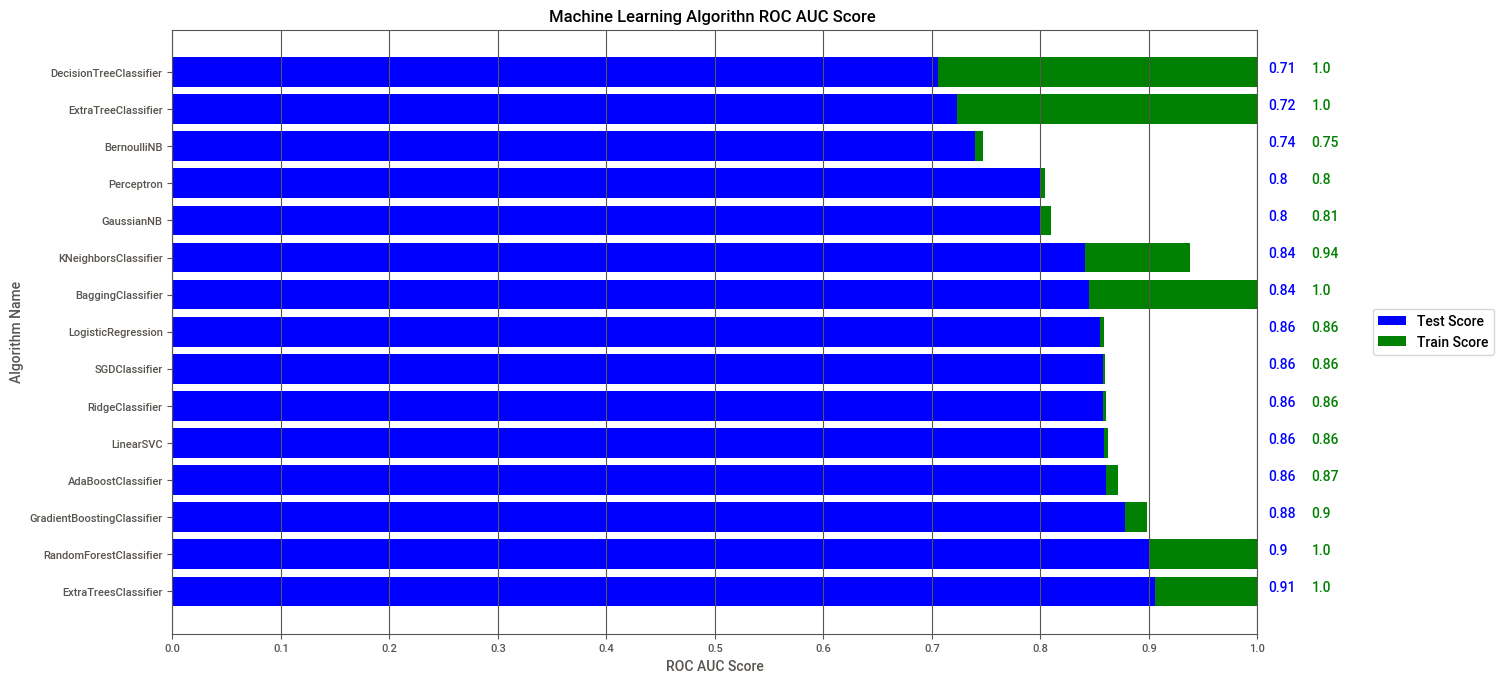

In [124]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Test ROC_AUC Mean'], color = 'b' , label = 'Test Score')
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Train ROC_AUC Mean']-MLA_Compare['MLA Test ROC_AUC Mean'], color = 'g', label = "Train Score", left=MLA_Compare['MLA Test ROC_AUC Mean'] )
for index, data in enumerate(MLA_Compare['MLA Test ROC_AUC Mean']):
    plt.text(x=1.01 , y = index, s=MLA_Compare['MLA Test ROC_AUC Mean'][index].round(2) ,color = "b")
    plt.text(x=1.05 , y = index, s=MLA_Compare['MLA Train ROC_AUC Mean'][index].round(2), color = "g")
plt.xlim(0,1)
ax.grid(axis="x")
plt.ylabel("Algorithm Name")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('Machine Learning Algorithn ROC AUC Score ')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

## Reduzindo o Overfit no algoritmo de Exta Trees Classifier
Para tentar reduzir o overfit foi aplicado a alteração de alguns parâmetros e em seguida foi realizado a validação cruzada apenas
utilizando o algoritmo de Extra Trees Classifier

Com o gráfico pode-se notar que os valores de Treino e Teste foram bem próximos.
Olhando para os outro algoritmos realizados na linha acima muitos chegaram bem próximo destes resultados (*Logistic Regression, SGDC, Ridge e AdaBoost*),\
porém neste projeto estarei optando pelo **Extra Trees** por ser um algoritmo que pode-se ser mais facilmente representável. 

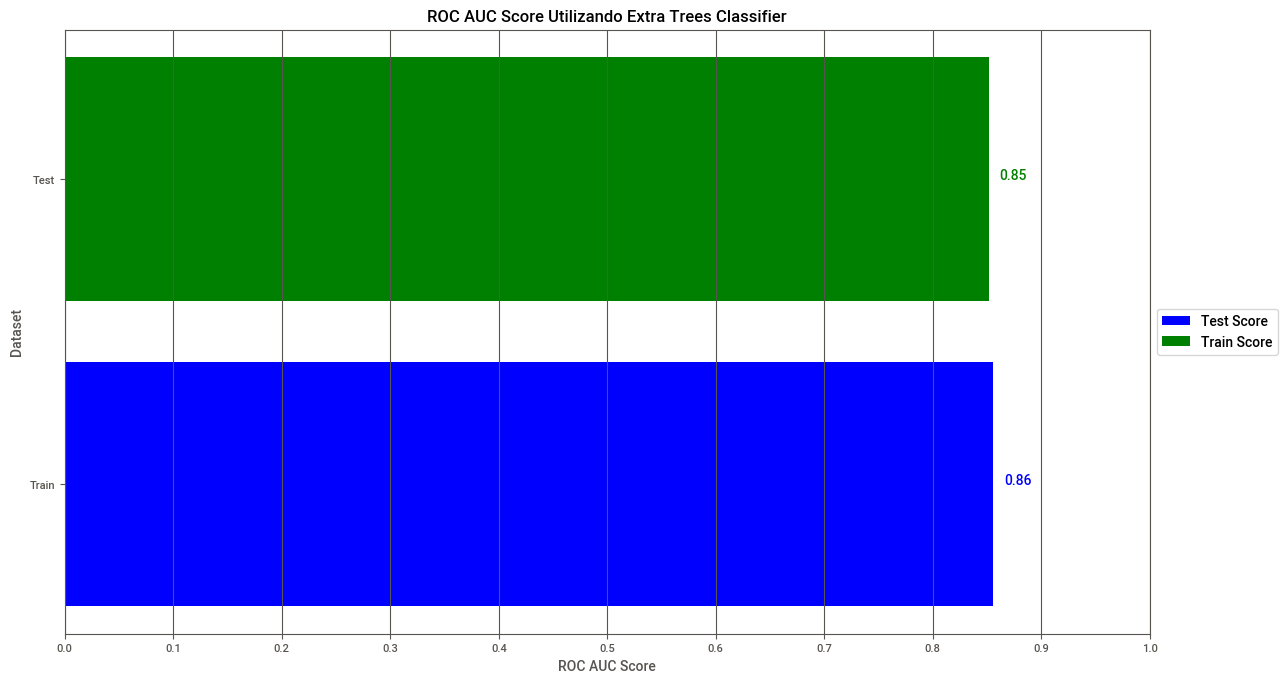

In [125]:
reduce_overfit_params = {  "min_samples_split" : 0.02, 
                            "min_samples_leaf" : 0.02,
                            "max_depth" : 25}
pipeline_Ex_tree = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.ExtraTreesClassifier(**reduce_overfit_params))])
cv_results_stp1 = cross_validate(pipeline_Ex_tree, X= X_train, y= y_train, cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')

fig1, ax1 = plt.subplots(figsize = (14, 8))
ax1.barh(y="Train", width=cv_results_stp1['train_score'].mean(), color = 'b' , label = 'Test Score')
ax1.barh(y="Test", width=cv_results_stp1['test_score'].mean(), color = 'g', label = "Train Score" )
plt.text(x=cv_results_stp1['train_score'].mean()+0.01 , y = "Train", s=cv_results_stp1['train_score'].mean().round(2) ,color = "b")
plt.text(x=cv_results_stp1['test_score'].mean()+0.01 , y = "Test", s=cv_results_stp1['test_score'].mean().round(2), color = "g")
plt.xlim(0,1)
ax1.grid(axis="x")
plt.ylabel("Dataset")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('ROC AUC Score Utilizando Extra Trees Classifier')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [126]:
# functions para auxiliar a visualização dos resultados.

def report(y_true, X, pipe, titulo= None):
    y_pred = pipe.predict(X)
    print(titulo)
    print(classification_report(y_true, y_pred))

def plot_roc_curve(fpr, tpr, titulo = None):
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title("Curva ROC")
    plt.legend(title = "Base de dados", )
    plt.plot(fpr, tpr, label = titulo)
    plt.show()

## Plotando  as Variáveis de importância 
Ao plotar as variáveis de importância que o algoritmo esta considerando algumas coisas me chamaram a atenção, os 3 maiores valores revelam que a atividade do vendedor na plataforma interfere diretamente  em se o vendedor irá realmente permanecer vendendo nos próximos meses, mostrando que a venda constante tende a interferir no resultado.

Uma variável interessante foi a **Avaliação do vendedor** que posso sugerir que é levado em consideracão pelo comprador na hora da venda diferentemente das outras variáveis ela não esta no controle do vendedor e sim da avaliação recebida por vendas passadas.

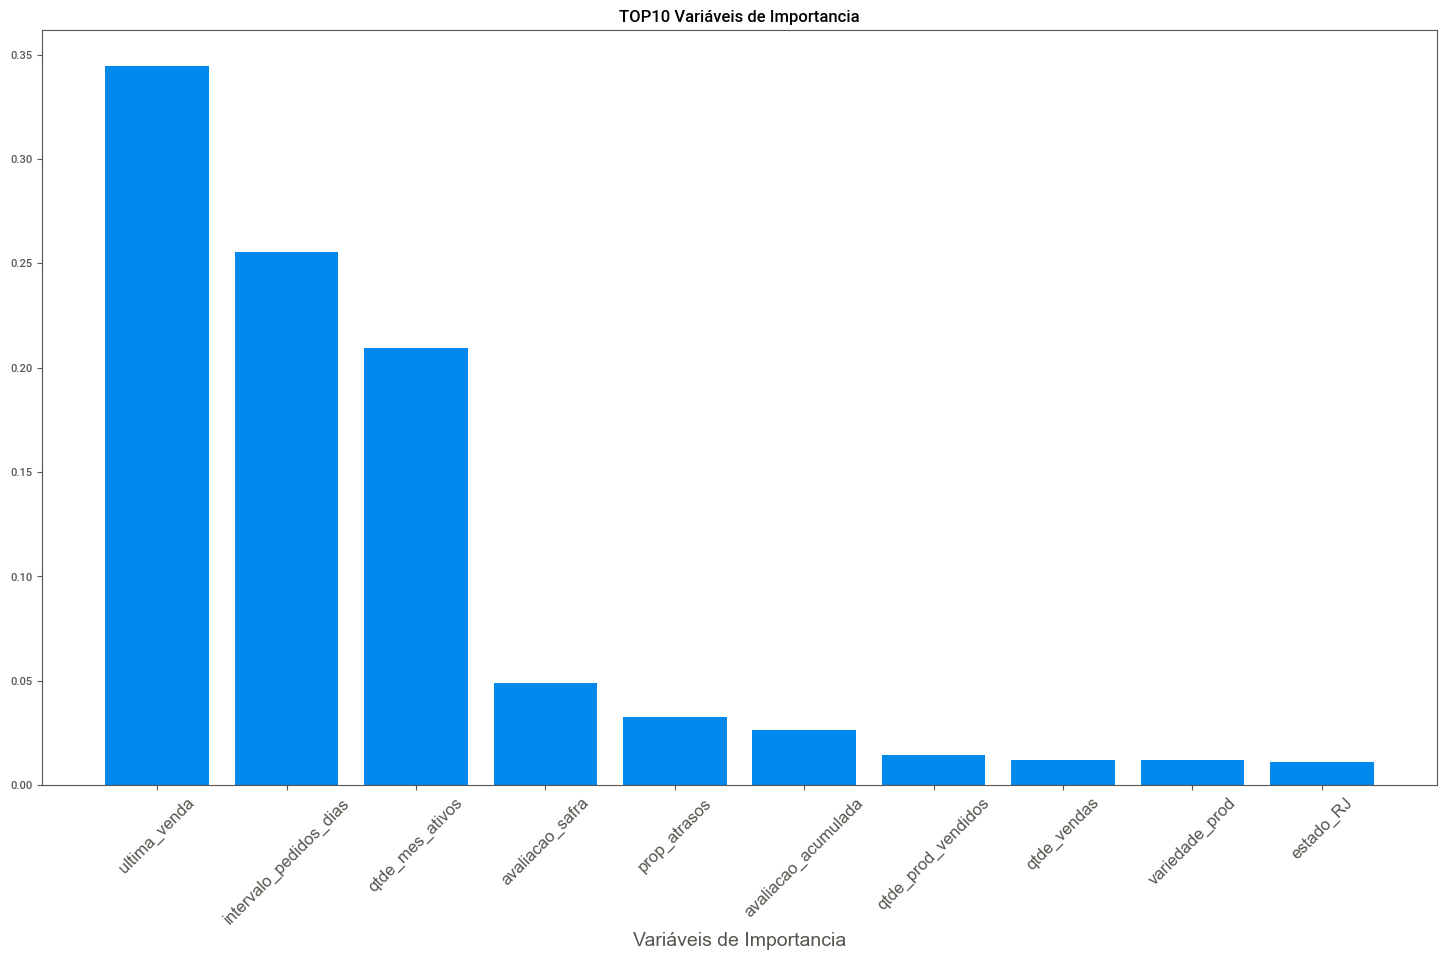

In [127]:
pipeline_Ex_tree.fit(X_train[features], y_train)
features_values  = pipeline_Ex_tree['alg'].feature_importances_
cat_col_names = list(pipeline_Ex_tree.named_steps['prep'].transformers_[1][1].get_feature_names(cat_features))
col_names = num_features + cat_col_names
features_importances = pd.Series(index= col_names, data = features_values)
features_importances.sort_values(ascending=False, inplace=True)

#Plotando o TOP10 das Variáveis de Importancia
ticks_font = {'fontname':'Arial', 'size':'12'}
axis_font = {'fontname':'Arial', 'size':'14'}
fig, ax = plt.subplots(figsize = (18, 10))
ax = plt.bar(x=features_importances.index[:10], height= features_importances.values[:10])
plt.title("TOP10 Variáveis de Importancia")
plt.xlabel( "Variáveis de Importancia", **axis_font)
plt.xticks(rotation=45, **ticks_font)
plt.show()

Plotando a curva ROC podemos ver que tanto o dataset de Treino e Out Of Time(OOT), mostraram valores bem próximos,
tambem uma outra métrica boa para ser utilizada nesse caso é o F1 Score.

Test Dataset
              precision    recall  f1-score   support

           0       0.78      0.36      0.49      1191
           1       0.76      0.95      0.85      2618

    accuracy                           0.77      3809
   macro avg       0.77      0.65      0.67      3809
weighted avg       0.77      0.77      0.74      3809

OOT Dataset
              precision    recall  f1-score   support

           0       0.82      0.42      0.56       604
           1       0.76      0.95      0.85      1177

    accuracy                           0.77      1781
   macro avg       0.79      0.69      0.70      1781
weighted avg       0.78      0.77      0.75      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.8536432205123863
AUC SCORE OOT Dataset: 0.8641835511768048


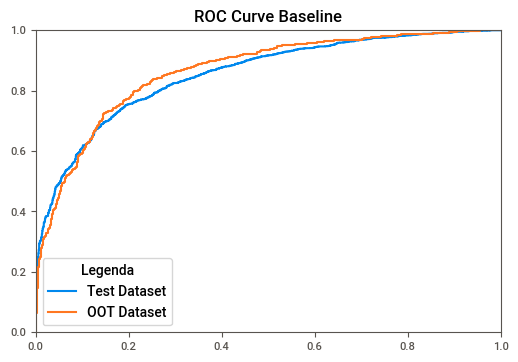

In [128]:
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
df_test_pred = pipeline_Ex_tree.predict(X_test)
df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
df_oot_pred = pipeline_Ex_tree.predict(df_oot[features])
pred_oot_proba =  pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba )}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba )}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

## Otimizacão dos Hyperparametros

Como o resultado obtido com o Extra Trees foi bem semelhante aos outros, resolvi efetuar o Randomized Search tanto com a Logistic Regression quanto com a Extra Trees e verificar a perfomance de ambos.  
Nesta etapa selecionei alguns parametros para serem testados, em função do tempo longo de processamento estou utilizando o Randomized Search para localizar melhores parametros.

In [129]:
pipeline_log_regr = Pipeline([   ('prep' , preparation),
                                ('alg' , linear_model.LogisticRegression(max_iter=500, class_weight="balanced" ))])

grid_logi_regre = {     "alg__penalty" : ['l1', 'l2', 'elasticnet'],
                        "alg__C" : np.logspace(-4, 50, 100)}

otimizacao_regression = RandomizedSearchCV(     estimator=pipeline_log_regr, param_distributions=grid_logi_regre, 
                                                n_iter=3000, n_jobs=-1, cv = cv_split, 
                                                scoring='roc_auc', verbose=1,
                                                random_state=123)
otimizacao_regression.fit(X_train[features], y_train)
resultados_reg = pd.DataFrame(otimizacao_regression.cv_results_)
resultados_reg.sort_values(by='rank_test_score', ascending= True, inplace=True)

/opt/anaconda3/envs/AutoMLPycarret/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 300 is smaller than n_iter=3000. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1956 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2606 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.1min finished


              precision    recall  f1-score   support

           0       0.59      0.80      0.68      1191
           1       0.89      0.75      0.81      2618

    accuracy                           0.76      3809
   macro avg       0.74      0.77      0.75      3809
weighted avg       0.80      0.76      0.77      3809

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       604
           1       0.88      0.78      0.83      1177

    accuracy                           0.79      1781
   macro avg       0.77      0.79      0.77      1781
weighted avg       0.80      0.79      0.79      1781

Test Dataset
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1191
           1       0.86      0.81      0.84      2618

    accuracy                           0.78      3809
   macro avg       0.75      0.76      0.75      3809
weighted avg       0.79      0.78      0.78      3809

OOT Da

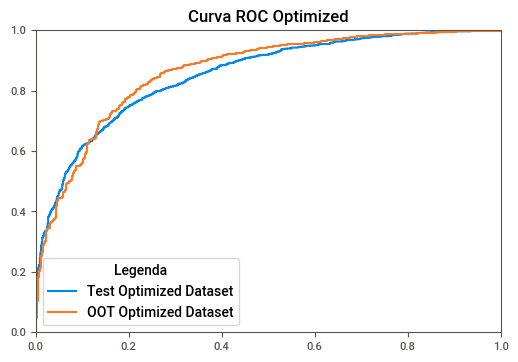

In [130]:
pipeline_log_regr.set_params(**otimizacao_regression.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

threshold = 0.57
preds = np.where(pipeline_log_regr.predict_proba(X_test)[:,1]>threshold, 1,0)
print(classification_report(y_test, preds))

preds_oot = np.where(pipeline_log_regr.predict_proba(df_oot[features])[:,1]>threshold, 1,0)
print(classification_report(df_oot[target], preds_oot))

report(y_test,X_test, pipeline_log_regr, "Test Dataset")
opt_df_test_pred_proba = pipeline_log_regr.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_log_regr, "OOT Dataset")
opt_df_test_oot_proba = pipeline_log_regr.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
roc_auc_score_test = roc_auc_score(y_test,opt_df_test_pred_proba ).round(4)
roc_auc_score_oot = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(4)
print(f'Optimized AUC SCORE Test Dataset: {roc_auc_score_test}')
print(f'Optimized AUC SCORE OOT Dataset: {roc_auc_score_oot}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC Optimized")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

In [131]:
# Otimizando os parametros do algoritmo com Randomized Search

min_samples = np.linspace(start=0.02, stop=0.05 )

grid = {    "alg__n_estimators" : [100,200,500,1000],
            "alg__criterion" : ['gini','entropy'],
            "alg__max_depth" : [5,10,15,20,25],
            "alg__min_samples_split" : min_samples,
            "alg__min_samples_leaf" : min_samples}


otimizacao_tree = RandomizedSearchCV(    estimator=pipeline_Ex_tree, param_distributions=grid, 
                                    n_iter=600, n_jobs=-1, cv = cv_split, 
                                    scoring='roc_auc', verbose=1,
                                    random_state=123)
otimizacao_tree.fit(X_train[features], y_train)
resultados_tree = pd.DataFrame(otimizacao_tree.cv_results_)
resultados_tree.sort_values(by='rank_test_score', ascending= True, inplace=True)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 31.1min finished


              precision    recall  f1-score   support

           0       0.65      0.70      0.68      1191
           1       0.86      0.83      0.84      2618

    accuracy                           0.79      3809
   macro avg       0.75      0.77      0.76      3809
weighted avg       0.79      0.79      0.79      3809

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       604
           1       0.85      0.87      0.86      1177

    accuracy                           0.81      1781
   macro avg       0.79      0.79      0.79      1781
weighted avg       0.81      0.81      0.81      1781

Test Dataset
              precision    recall  f1-score   support

           0       0.80      0.33      0.47      1191
           1       0.76      0.96      0.85      2618

    accuracy                           0.76      3809
   macro avg       0.78      0.65      0.66      3809
weighted avg       0.77      0.76      0.73      3809

OOT Da

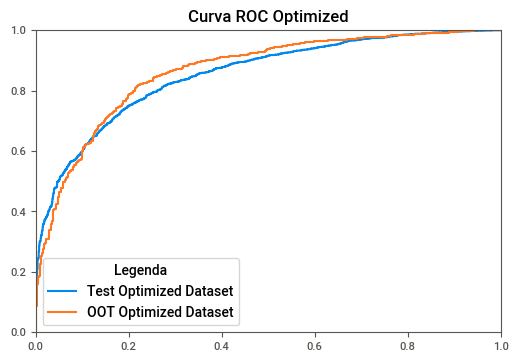

In [132]:
pipeline_Ex_tree.set_params(**otimizacao_tree.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

threshold = 0.65
preds = np.where(pipeline_Ex_tree.predict_proba(X_test)[:,1]>threshold, 1,0)
print(classification_report(y_test, preds))
preds_tree_ = np.where(pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]>threshold, 1,0)
print(classification_report(df_oot[target], preds_tree_))


report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
opt_df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
opt_df_test_oot_proba = pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
roc_auc_score_test = roc_auc_score(y_test,opt_df_test_pred_proba ).round(4)
roc_auc_score_oot = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(4)
print(f'Optimized AUC SCORE Test Dataset: {roc_auc_score_test}')
print(f'Optimized AUC SCORE OOT Dataset: {roc_auc_score_oot}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC Optimized")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

In [133]:
assert False

AssertionError: 

In [ ]:
# Preparando para o arquivo Pickle

pick = {    "cols_num" : num_features,
            "cat_features" : cat_features,
            "features" : features,
            "target" : target,
            "random_state" : 123,
            "cv_split" : ShuffleSplit(n_splits=10),
            "grid_parametres" : grid,
            "pipeline_algoritmo" : otimizacao.best_estimator_,
            "roc_auc_score_test" : roc_auc_score_test,
            "roc_auc_score_oot" : roc_auc_score_oot}

historical = pd.Series(pick)
print("Creating a Pickle File")
historical.to_pickle(os.path.join(dir_project, 'Modelling/modelo_otimizado.pkl'))

Creating a Pickle File


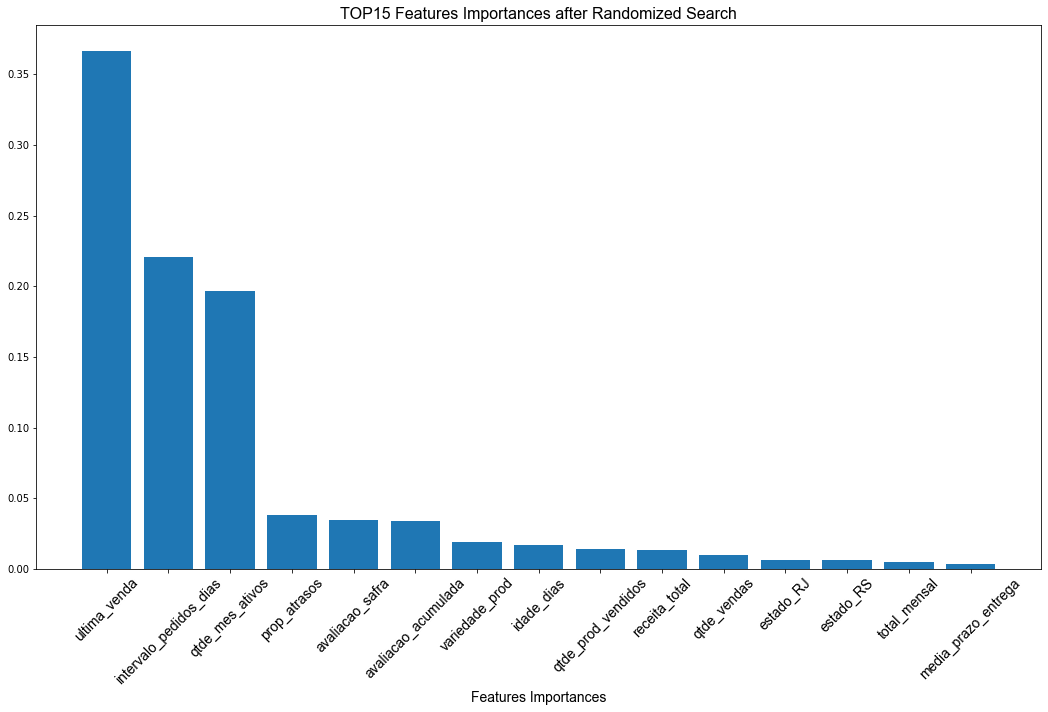

In [ ]:
features_values_opt  = pipeline_Ex_tree['alg'].feature_importances_
cat_col_names = list(pipeline_Ex_tree.named_steps['prep'].transformers_[1][1].get_feature_names(cat_features))
features_importances_opt = pd.Series(index= col_names, data = features_values_opt)
features_importances_opt.sort_values(ascending=False, inplace=True)

#Plotting the TOP15 Features Importances
title_font = { 'fontname':'Arial', 'size':'16'}
ticks_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Arial', 'size':'14'}
fig, ax = plt.subplots(figsize = (18, 10))
ax = plt.bar(x=features_importances_opt.index[:15], height= features_importances_opt.values[:15])
plt.title("TOP15 Features Importances after Randomized Search" , **title_font)
plt.xlabel("Features Importances", **axis_font)
plt.xticks(rotation=45, **ticks_font)
plt.show()

In [ ]:
min_samples = np.linspace(start=0.02, stop=0.05 )

parameters = \
        [ \
            {
                'clf': [linear_model.LogisticRegression()],
                "clf__penalty" : ['l1', 'l2', 'elasticnet'],
                "clf__C" : np.logspace(-4, 50, 100)
            },

            {
                'clf': [ensemble.ExtraTreesClassifier()],
                "clf__n_estimators" : [100,200,500,1000],
                "clf__criterion" : ['gini','entropy'],
                "clf__max_depth" : [5,10,15,20,25],
                "clf__min_samples_split" : min_samples,
                "clf__min_samples_leaf" : min_samples
            }
        ]

result_col_names = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__n_estimators', 'param_clf__min_samples_split',
       'param_clf__min_samples_leaf', 'param_clf__max_depth',
       'param_clf__criterion', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score']


results_rand_search_clf = []

for params in parameters:
    #Selecionando o Classifier
    alg = params['clf'][0]
    #Tirando ele o Classifier do dict e deixando apenas os parametros de grid
    params.pop('clf')
    #Criando a Pipeline
    steps = [('prep' , preparation),('clf',alg)]
    # Definido os passos pode-se realizar o Grid Searh
    grid = RandomizedSearchCV(Pipeline(steps), param_distributions=params,
                        n_iter=600, n_jobs=-1, cv = cv_split, 
                        scoring='roc_auc', verbose=1,
                        random_state=123)
    print(f"Inicializando o Grid Search do clf {alg}")
    grid.fit(X_train[features], y_train)
    
    #Guardando os resultados
    results_rand_search_clf.append(grid.cv_results_)


resultados = pd.DataFrame(results_rand_search_clf)

Inicializando o Grid Search do clf {alg}
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/opt/anaconda3/envs/AutoMLPycarret/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 300 is smaller than n_iter=600. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.2min finished
/opt/anaconda3/envs/AutoMLPycarret/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (sta

Inicializando o Grid Search do clf {alg}
Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 26.8min finished


TypeError: __init__() got an unexpected keyword argument 'col_names'

In [ ]:
dassda = pd.DataFrame(results_rand_search_clf)

In [ ]:
dassda

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__penalty,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,param_clf__criterion
0,"[0.07355351448059082, 0.11766910552978516, 0.0...","[0.007139527479774753, 0.009800837204268668, 0...","[0.0, 0.014731860160827637, 0.0, 0.0, 0.010950...","[0.0, 0.0034119948884245026, 0.0, 0.0, 0.00107...","[l1, l2, elasticnet, l1, l2, elasticnet, l1, l...","[0.0001, 0.0001, 0.0001, 0.0003511191734215131...","[{'clf__penalty': 'l1', 'clf__C': 0.0001}, {'c...","[nan, 0.8328234643054787, nan, nan, 0.83424903...","[nan, 0.8302480778276076, nan, nan, 0.83149615...","[nan, 0.8457773274794551, nan, nan, 0.84739389...","[nan, 0.8477863120486071, nan, nan, 0.84899690...","[nan, 0.8272219373773448, nan, nan, 0.82883965...","[nan, 0.8252797696653629, nan, nan, 0.82650659...","[nan, 0.8307926564750385, nan, nan, 0.83265803...","[nan, 0.8368050488837006, nan, nan, 0.83844210...","[nan, 0.8333419053185271, nan, nan, 0.83450613...","[nan, 0.8174693321217629, nan, nan, 0.81880508...","[nan, 0.8327545831502885, nan, nan, 0.83418936...","[nan, 0.008617159266462494, nan, nan, 0.008635...","[124, 100, 213, 214, 99, 215, 216, 98, 217, 21...",NaN,NaN,NaN,NaN,NaN
1,"[1.3279087543487549, 2.9681196451187133, 2.908...","[0.026631656219844882, 0.05735760329701476, 0....","[0.07315945625305176, 0.15363051891326904, 0.1...","[0.006521221638840711, 0.012238050870114182, 0...",NaN,NaN,"[{'clf__n_estimators': 200, 'clf__min_samples_...","[0.854366353071389, 0.8490359712230215, 0.8517...","[0.8472507462825583, 0.8458722774075471, 0.845...","[0.8584982550939997, 0.8604480468310256, 0.861...","[0.857773701708128, 0.8604746073598534, 0.8619...","[0.8508999133678682, 0.8472401478050247, 0.841...","[0.8435100680863392, 0.8452620237577864, 0.843...","[0.8446181609953323, 0.855632580818685, 0.8545...","[0.8601889683350359, 0.8584242302641178, 0.858...","[0.842552893045003, 0.8461437755698423, 0.8456...","[0.8349613811903679, 0.8418128123580192, 0.839...","[0.8494620441176022, 0.8510346473394923, 0.850...","[0.007833951956332168, 0.006639283919300623, 0...","[503, 302, 391, 282, 225, 260, 104, 271, 498, ...","[200, 500, 500, 100, 500, 200, 1000, 1000, 500...","[0.038979591836734696, 0.024285714285714285, 0...","[0.037142857142857144, 0.04448979591836735, 0....","[10, 15, 10, 10, 10, 10, 15, 25, 20, 15, 10, 5...","[gini, gini, gini, entropy, entropy, gini, ent..."


In [ ]:
grid.cv_results_

{'mean_fit_time': array([1.32790875, 2.96811965, 2.90827568, 0.72530453, 3.26923139,
        1.23377328, 6.67542467, 6.0888974 , 2.92318096, 1.42763629,
        0.65305562, 1.19282813, 3.33237097, 0.76272891, 3.3061368 ,
        6.09274518, 5.86891887, 3.07888787, 1.21244793, 0.64983759,
        0.68144081, 0.68261368, 1.22403839, 6.19337058, 2.91865857,
        0.72608185, 3.04113383, 7.24389699, 0.70689862, 1.26083121,
        0.65195894, 7.18149042, 6.55183012, 0.66575043, 0.73995872,
        0.77049556, 3.16360488, 1.33699095, 3.56255012, 3.19807851,
        6.50680919, 3.13233905, 1.31328843, 0.73912916, 7.77957916,
        3.53850644, 0.68258688, 3.09078867, 3.25511549, 2.92589121,
        1.23871741, 0.71746075, 6.69577067, 6.42190664, 6.55340629,
        1.3004631 , 0.71707563, 3.6340003 , 0.79272327, 3.38111303,
        1.23199608, 7.47132602, 3.29561632, 0.70313175, 0.70866656,
        7.5220063 , 6.28897216, 3.42313001, 1.31185749, 5.90195539,
        2.97864487, 6.51242857,

In [ ]:
results_rand_search_clf

[{'mean_fit_time': array([0.07355351, 0.11766911, 0.07124596, 0.05253694, 0.09268177,
         0.06350999, 0.05598404, 0.09473701, 0.06006453, 0.05652394,
         0.13696878, 0.06275325, 0.05088542, 0.14966104, 0.060041  ,
         0.05122645, 0.19511092, 0.07100139, 0.06215787, 0.29097536,
         0.07668304, 0.05474679, 0.39466133, 0.08398883, 0.05869846,
         0.53847232, 0.08731682, 0.05388422, 0.51405981, 0.08718991,
         0.05224409, 0.51487207, 0.08582821, 0.05340233, 0.51999645,
         0.08424666, 0.05093918, 0.51708181, 0.08917851, 0.06068318,
         0.52737746, 0.08975966, 0.05522537, 0.54190423, 0.09067526,
         0.05730104, 0.51265106, 0.0830869 , 0.07212133, 0.51230824,
         0.09207644, 0.05612974, 0.50397124, 0.08608377, 0.05401289,
         0.49856138, 0.08397374, 0.05897794, 0.47520616, 0.08426793,
         0.05201004, 0.51311603, 0.08703399, 0.05264378, 0.50695622,
         0.08820918, 0.05536733, 0.51332235, 0.08691964, 0.05297973,
         0.507437